# 0.0 IMPORTS

In [107]:
import json
import math
import random
import pickle
import requests
import warnings
import datetime
import inflection
import numpy   as np
import pandas  as pd
import seaborn as sns
import xgboost as xgb

from PIL                   import Image
from tabulate              import tabulate 
from scipy                 import stats  as ss 
from matplotlib            import pyplot as plt
from matplotlib.gridspec   import GridSpec
from boruta                import BorutaPy

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder 

warnings.filterwarnings('ignore')

## 0.1 Helper Funcitons

In [2]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


def mean_percentage_error(y, yhat):
    return np.mean((y-yhat)/y)


def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)/y))


def ml_error( model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse }, index=[0])


def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFOLD Number: {}'.format(k))

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error( model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'])
        mape_list.append( m_result['MAPE'])
        rmse_list.append( m_result['RMSE'])

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round  ( np.mean( mae_list ), 2 ).astype(str) + ' +/-' + np.round( np.std ( mae_list ), 2 ).astype(str),
                          'MAPE CV': np.round ( np.mean( mape_list ), 2 ).astype(str) + ' +/-' + np.round( np.std ( mape_list ), 2 ).astype(str),
                          'RMSE CV': np.round ( np.mean( rmse_list ), 2 ).astype(str) + ' +/-' + np.round( np.std ( rmse_list ), 2 ).astype(str) },
                           index=[0] )



## 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
646316,402,5,2013-11-29,6647,702,1,0,0,0,c,c,5830.0,9.0,2011.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


# 1.0 DATA DESCRIPTION

In [6]:
df1 = df_raw.copy()
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1 Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [8]:
print('Number of Rows: {}' .format(df1.shape[0]))
print('Number of Cols: {}' .format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [11]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month 
                                                if math.isnan(x['competition_open_since_month']) 
                                                else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year 
                                                if math.isnan(x['competition_open_since_year']) 
                                                else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week 
                                                if math.isnan(x['promo2_since_week']) 
                                                else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year 
                                                if math.isnan(x['promo2_since_year']) 
                                                else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 
                                                             if x ['month_map'] in x ['promo_interval'].split(',') else 0, axis=1)

In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [13]:
df1.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
451137,348,5,2014-05-23,10007,776,1,1,0,0,a,a,16490.0,5.0,2014.0,1,22.0,2012.0,"Jan,Apr,Jul,Oct",May,0
957174,175,6,2013-02-23,4693,667,1,0,0,0,c,a,4130.0,2.0,2013.0,0,8.0,2013.0,0,Feb,0
95836,1062,4,2015-05-07,6385,576,1,1,0,0,d,a,190.0,9.0,2012.0,1,40.0,2012.0,"Feb,May,Aug,Nov",May,1
809386,682,6,2013-07-06,7020,1316,1,0,0,0,b,a,150.0,9.0,2006.0,0,27.0,2013.0,0,Jul,0
767286,952,2,2013-08-13,7739,585,1,1,0,1,d,c,6300.0,10.0,2013.0,0,33.0,2013.0,0,Aug,0


In [14]:
df1.sample(5).T

,971753,754579,719286,387801,179781
store,259,510,897,1058,267
day_of_week,7,6,3,3,5
date,2013-02-10 00:00:00,2013-08-24 00:00:00,2013-09-25 00:00:00,2014-07-23 00:00:00,2015-02-20 00:00:00
sales,11012,4839,2840,5146,9037
customers,1955,502,261,561,1121
open,1,1,1,1,1
promo,0,0,1,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,1,0
store_type,b,a,c,a,c


## 1.6 Change Types

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [18]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


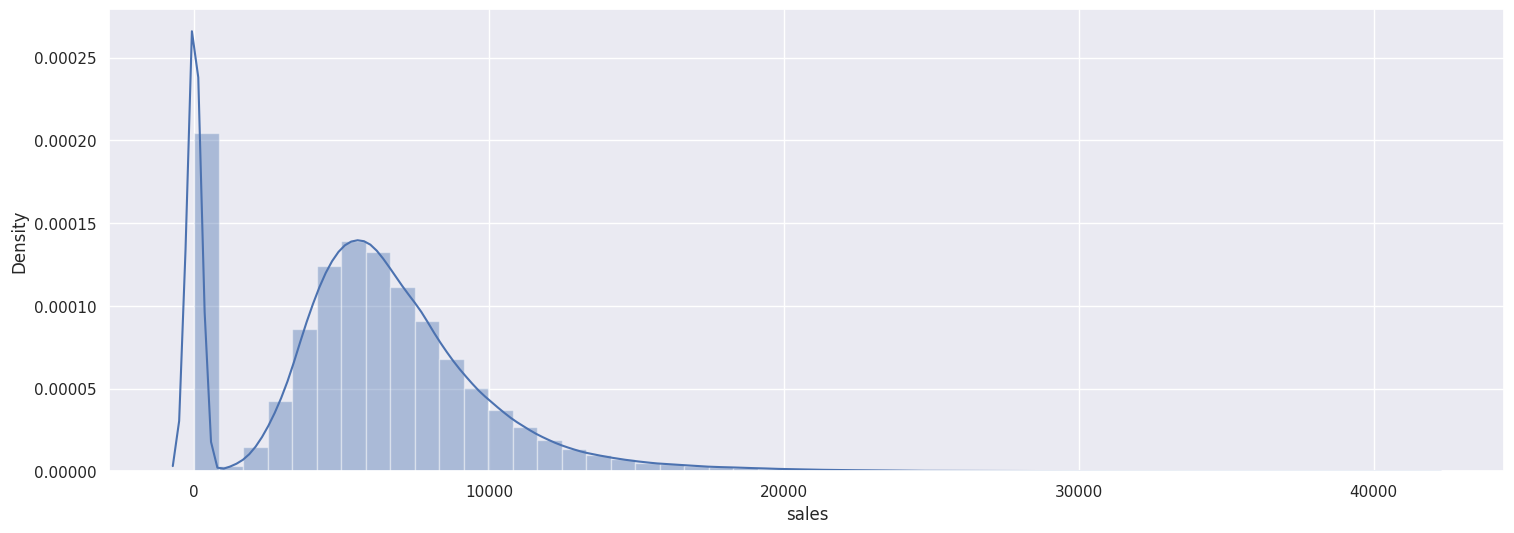

In [108]:
# Ajuste de tamanho para os gráficos criados
sns.set(rc={'figure.figsize':(18, 6)})

sns.distplot(df1['sales']);

### 1.7.2 Categorical Attributes

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

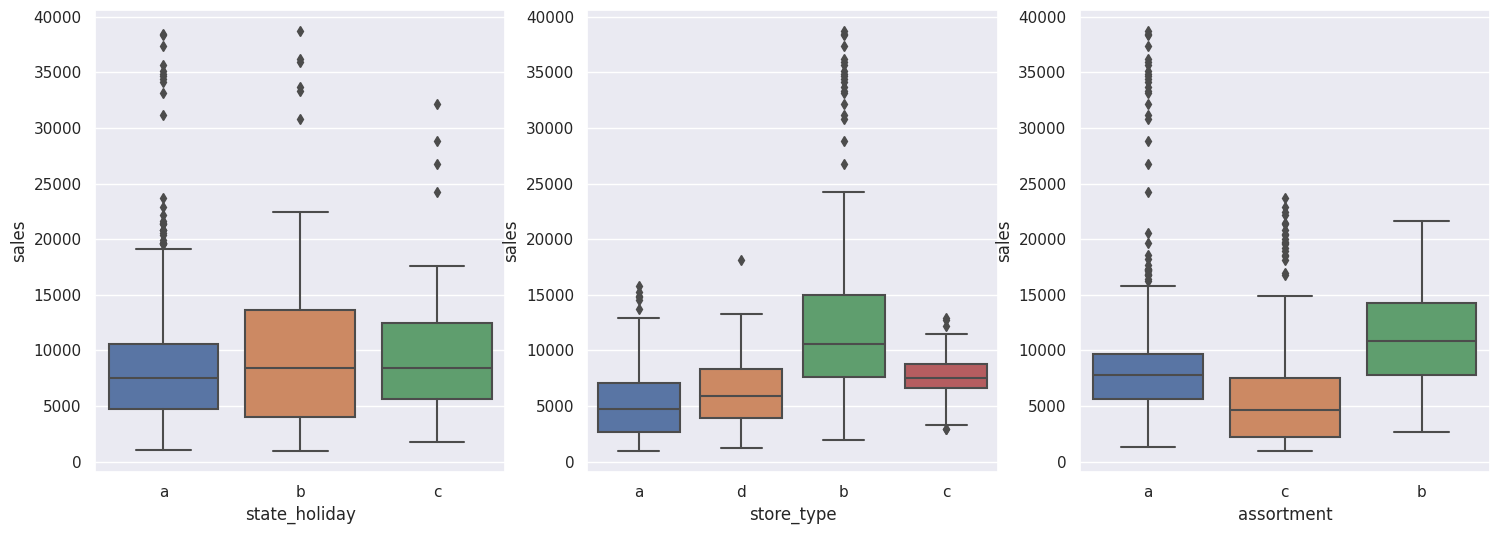

In [21]:
# Ajuste de tamanho para os gráficos criados
sns.set(rc={'figure.figsize':(18, 6)})


aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux)

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux)

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux)

# 2.0 FEATURE ENGINEERING

In [22]:
df2 =df1.copy()

## 2.1 Mapa Mental de Hipóteses

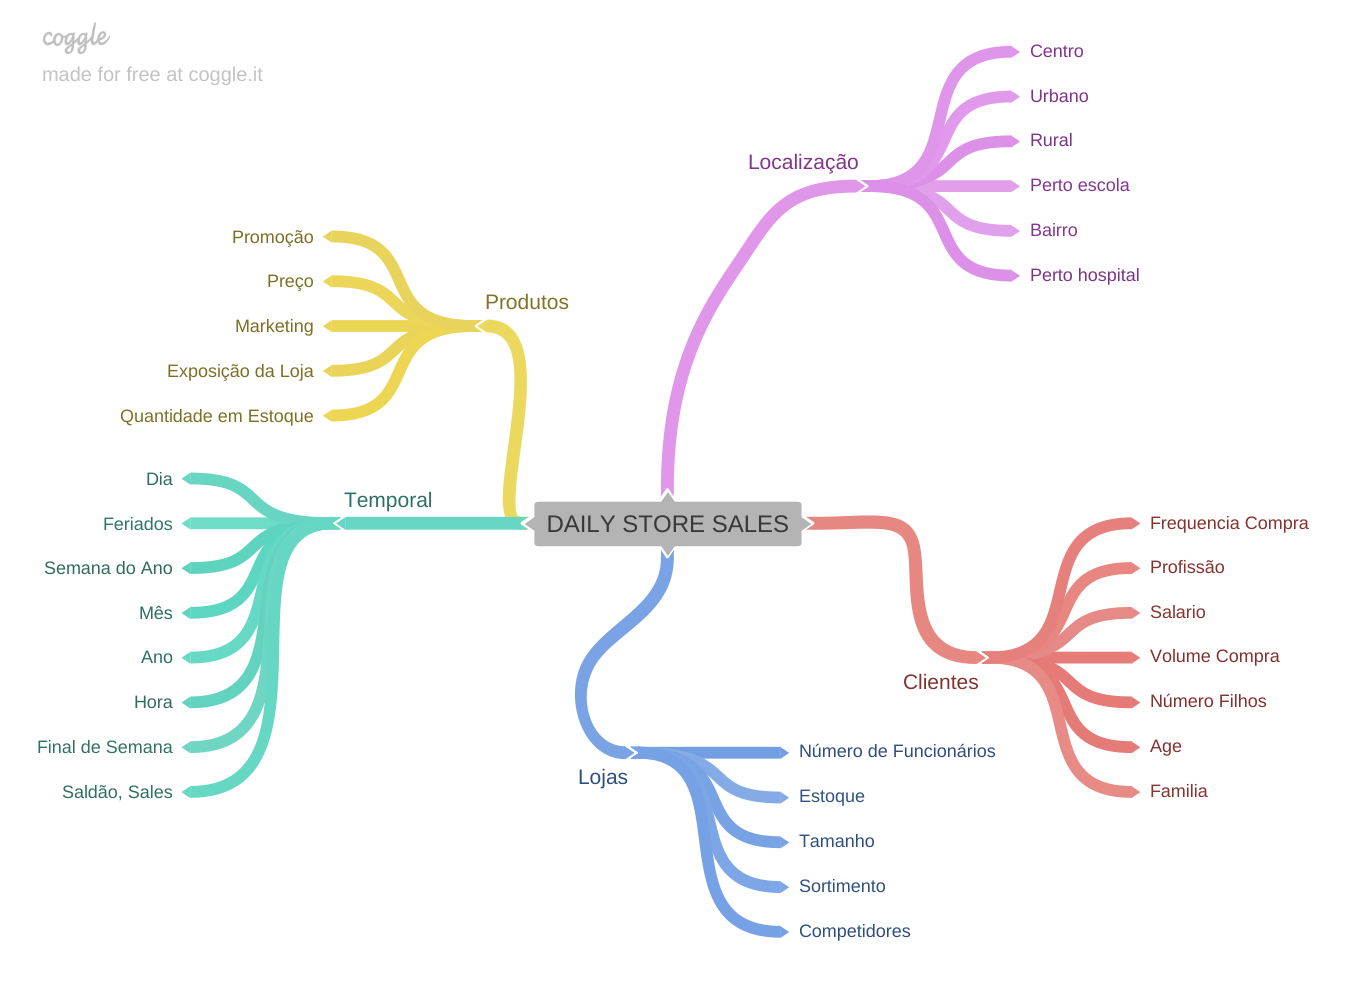

In [23]:
img = Image.open('img/mindmap.png')
width = img.width // 200
height = img.height // 200
img_resized = img.resize((width, height))
img

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses Lojas

**1.** Lojas com número maior de funcionários deveriam vender mais. 

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontes maiores), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depoiss do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depoiss do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [24]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

# competition since
df2['competiton_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competiton_since'])/30).apply(lambda x: x.days).astype(int)
                                      
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = (( df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [25]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem de Variáveis

In [26]:
df3 = df2.copy()
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competiton_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das Linhas

In [27]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [28]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competiton_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Análise Exploratória de Dados

In [29]:
df4 =df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

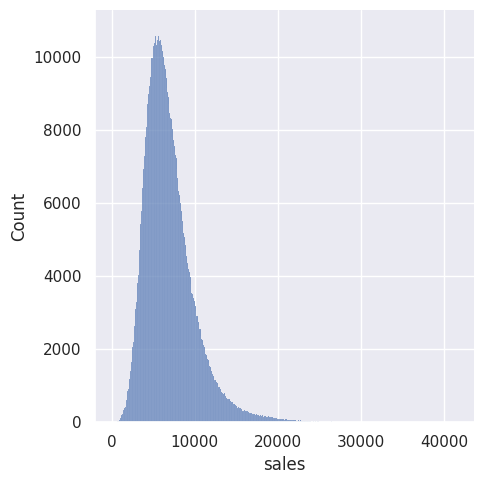

In [30]:
# Ajuste de tamanho para os gráficos criados
sns.set(rc={'figure.figsize':(60, 50)})
        
sns.displot(df4['sales'], kde=False)

### 4.1.2 Numerical Variable

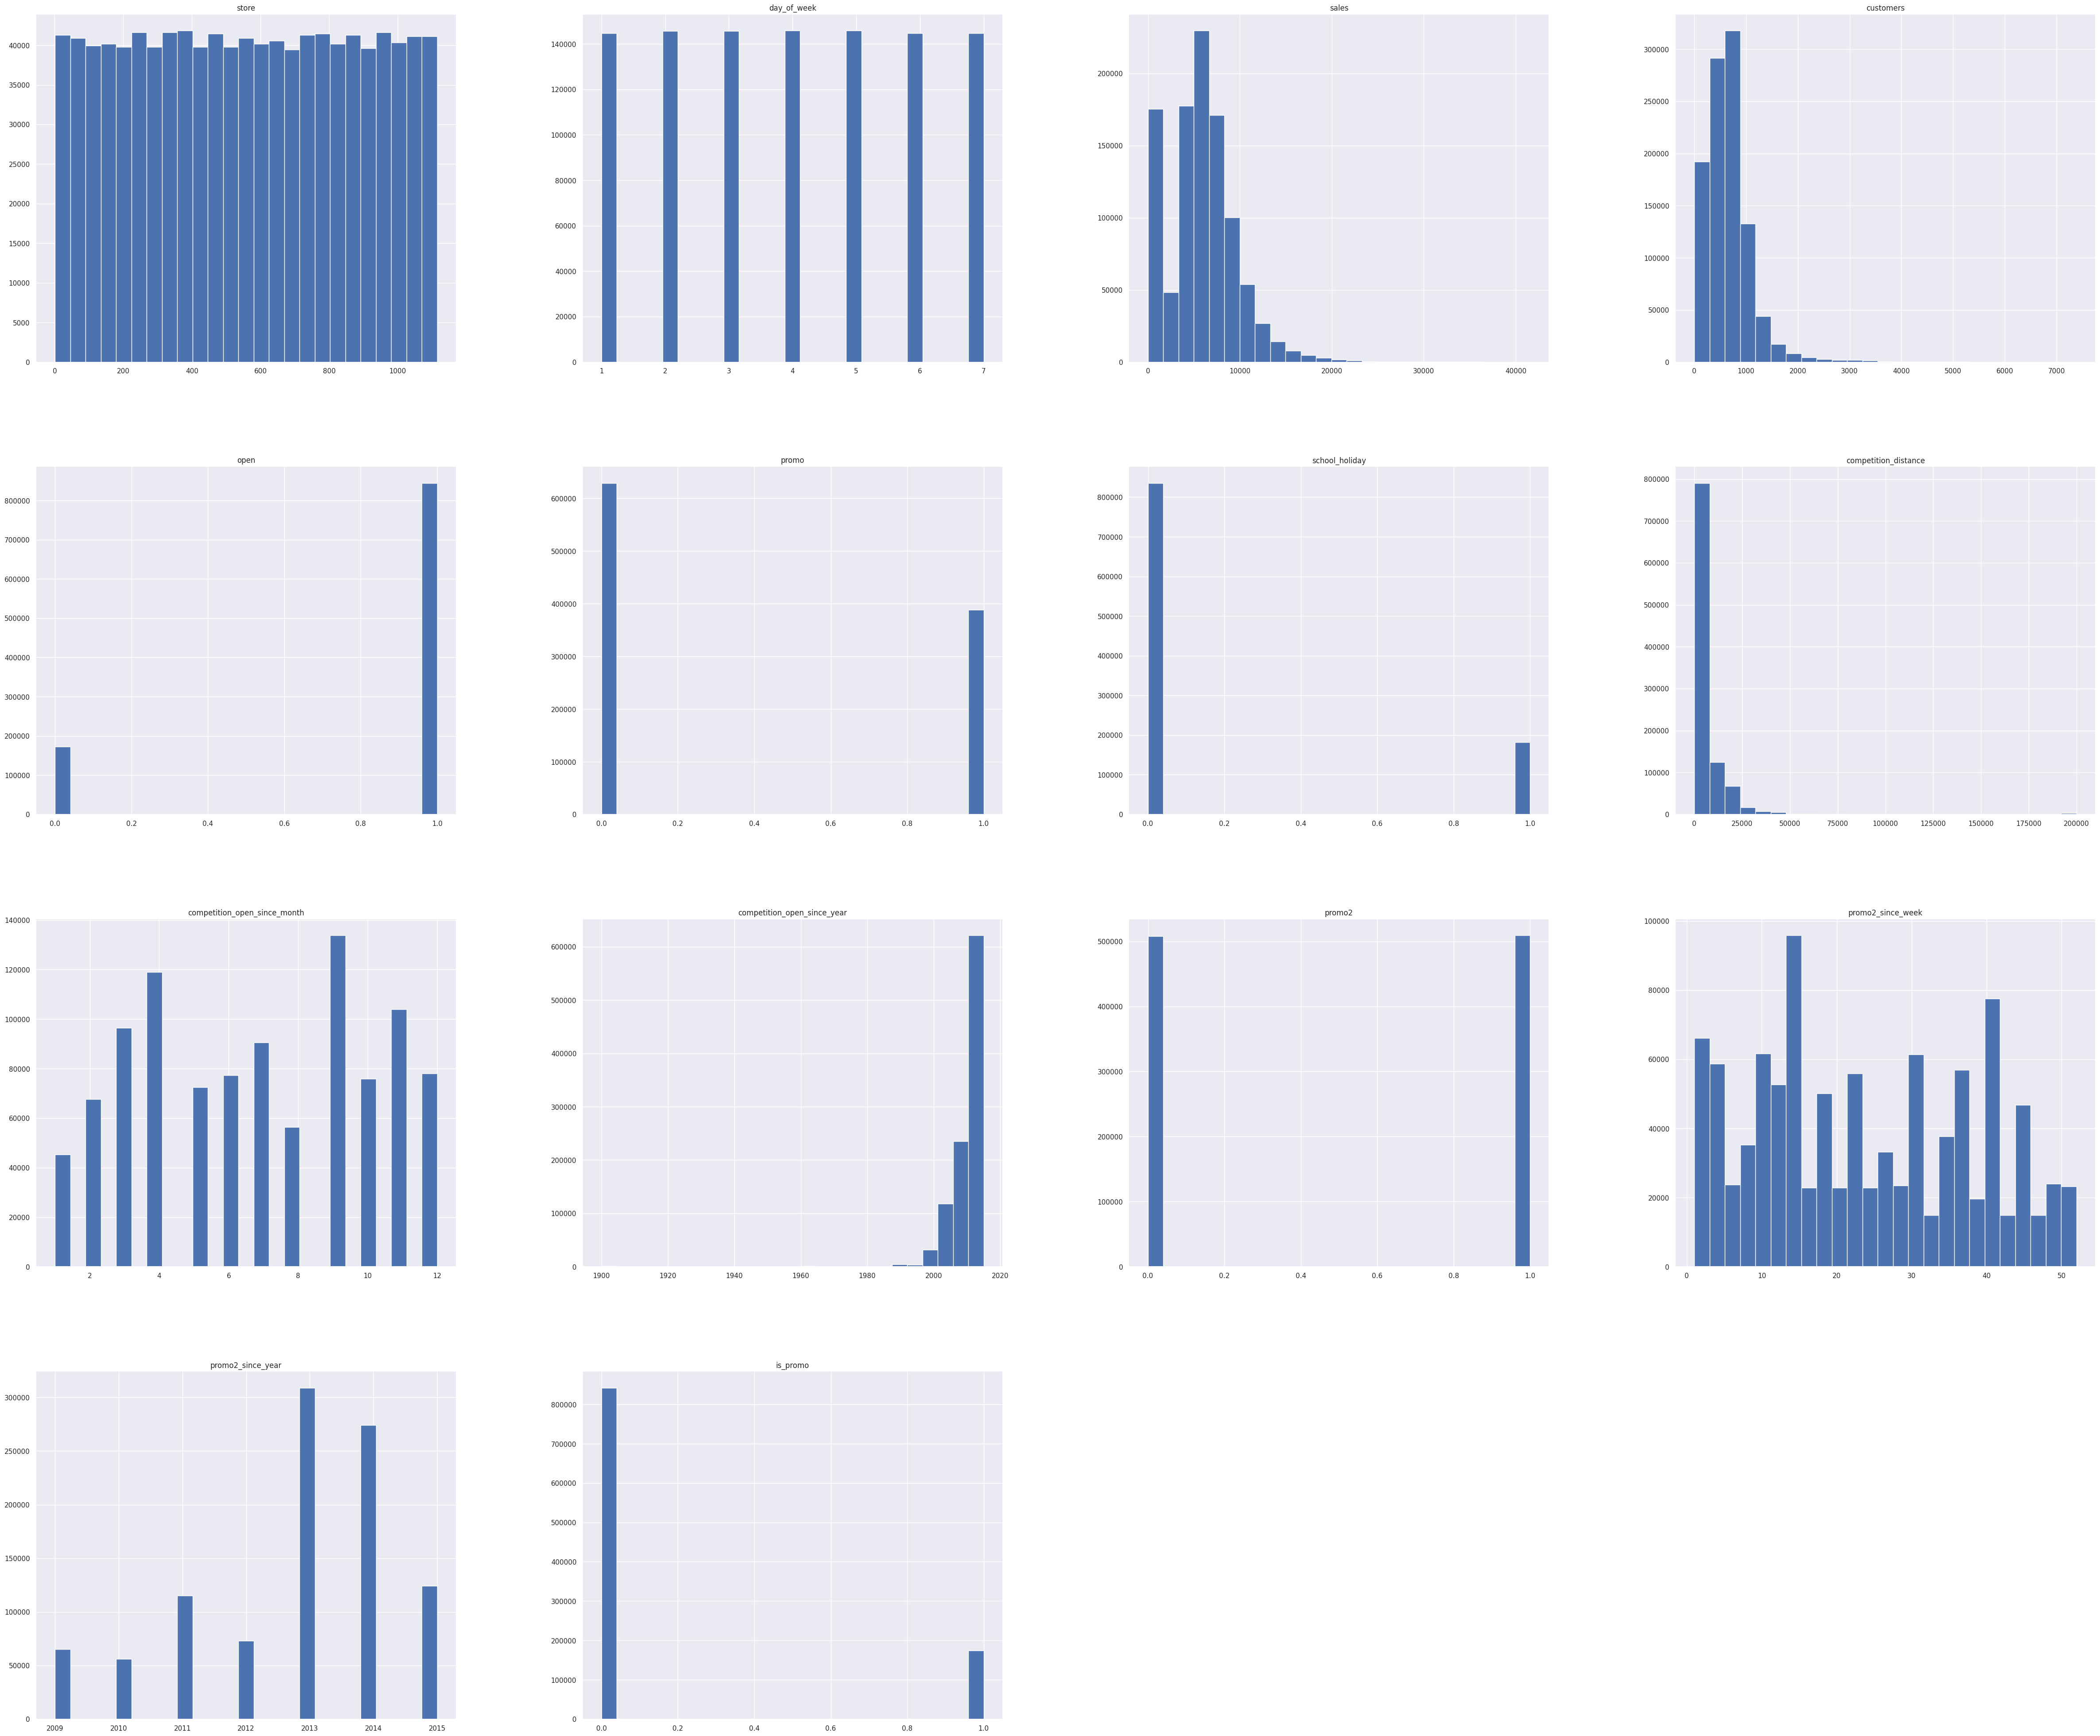

In [31]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

In [32]:
print(df4['state_holiday'].drop_duplicates())
print(df4['store_type'].drop_duplicates())
print(df4['assortment'].drop_duplicates())

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object
0     c
1     a
12    d
84    b
Name: store_type, dtype: object
0         basic
3      extended
258       extra
Name: assortment, dtype: object


<AxesSubplot: xlabel='sales', ylabel='Density'>

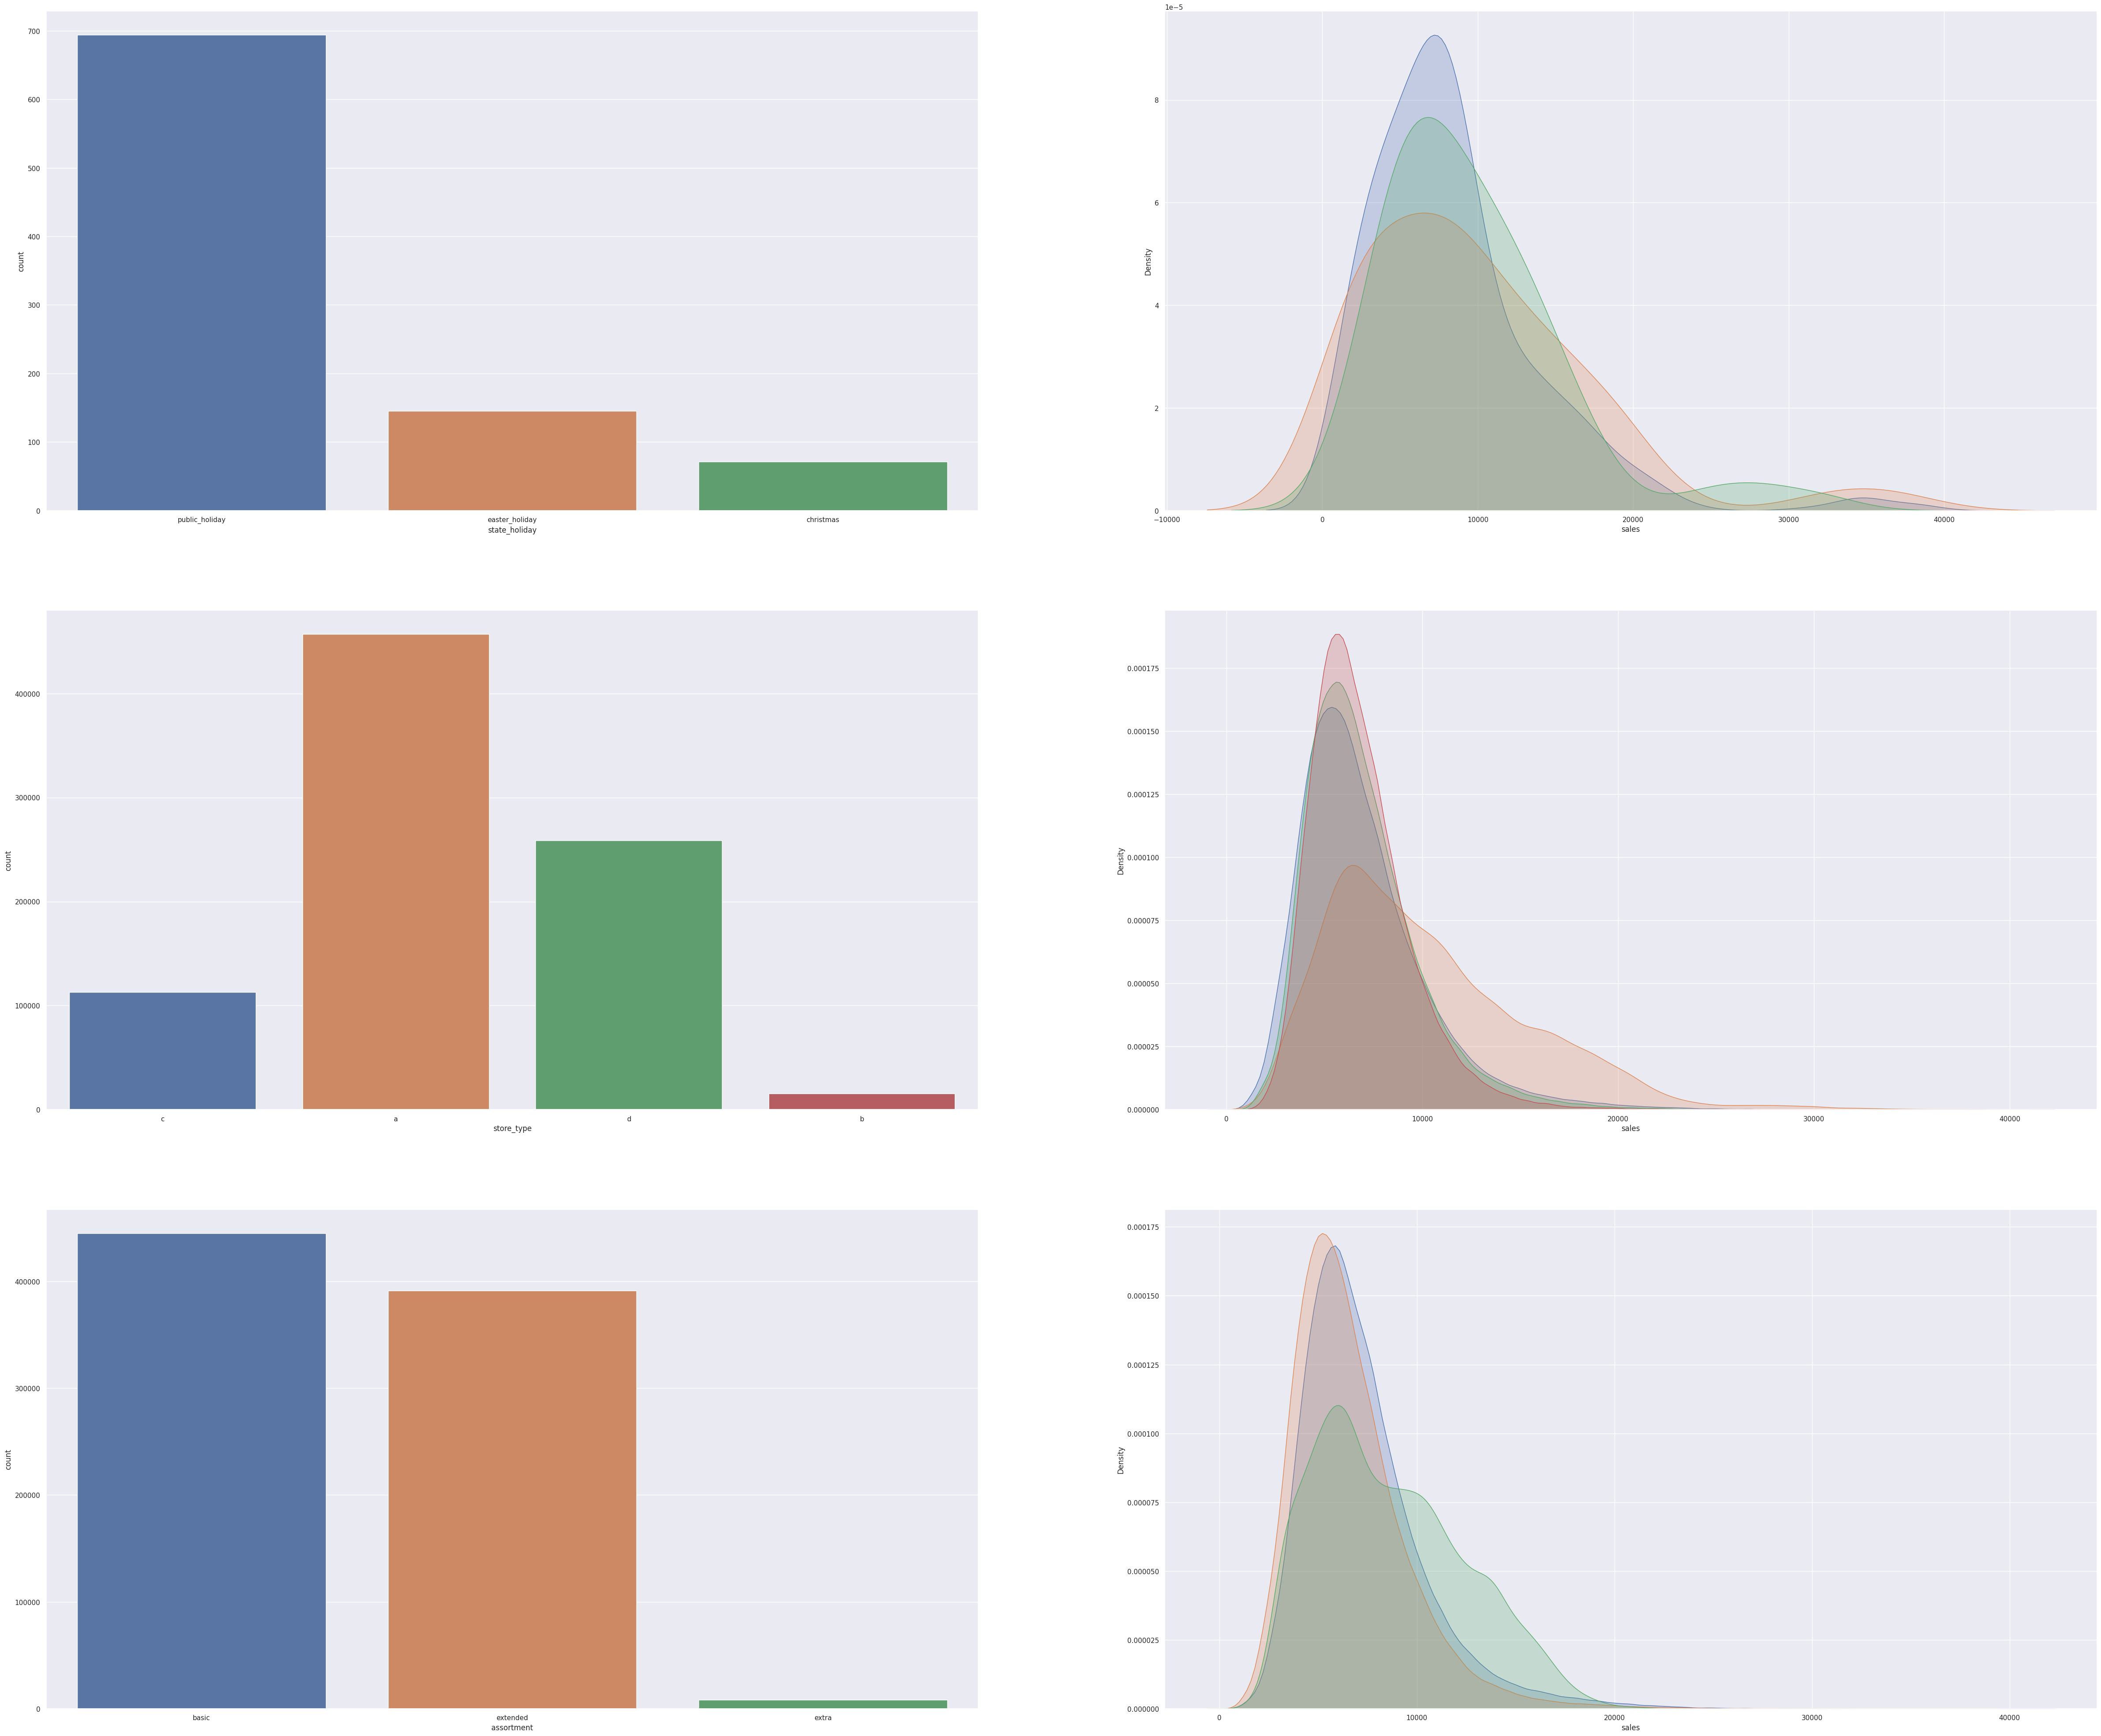

In [33]:
# state_holiday

plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'])
plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True )

# store_type

plt.subplot( 3, 2, 3 )
sns.countplot(x=df4['store_type'] )
plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True )

# assortment

plt.subplot( 3, 2, 5 )
sns.countplot(x=df4['assortment'] )
plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True )

## 4.2 Análise Bivariada

### 4.2.1 Hipóteses

#### **H1** Lojas com maior sortimentos deveriam vender mais
**Falsa** - lojas com maior sortimento vendem menos!

<AxesSubplot: xlabel='year_week'>

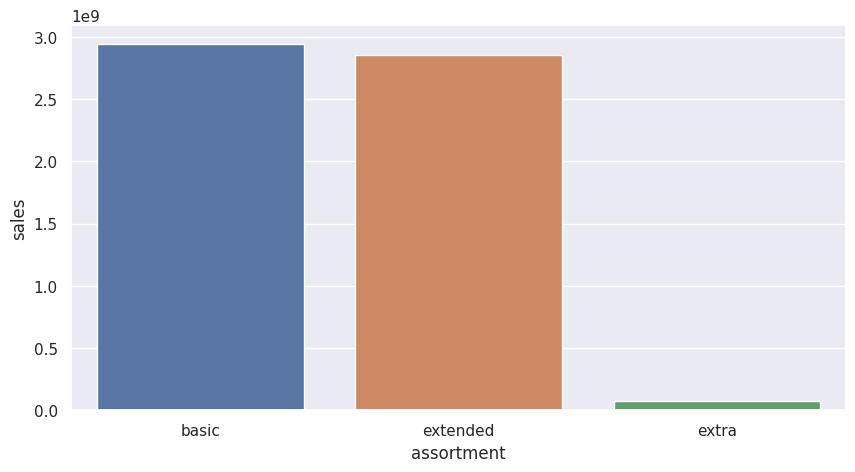

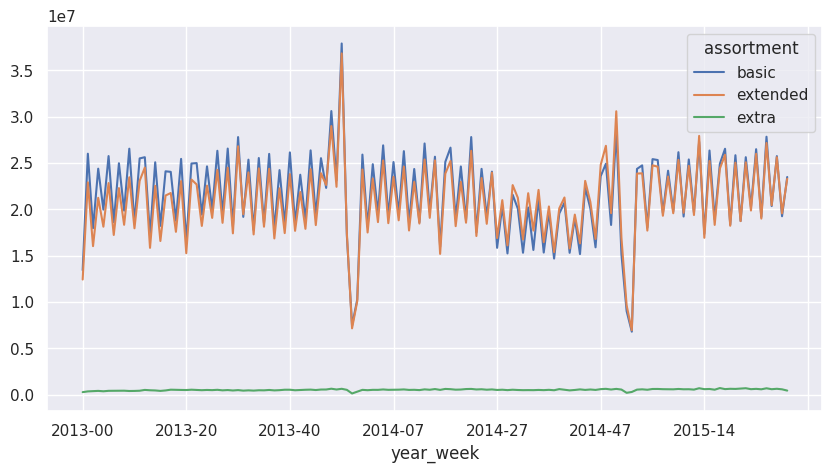

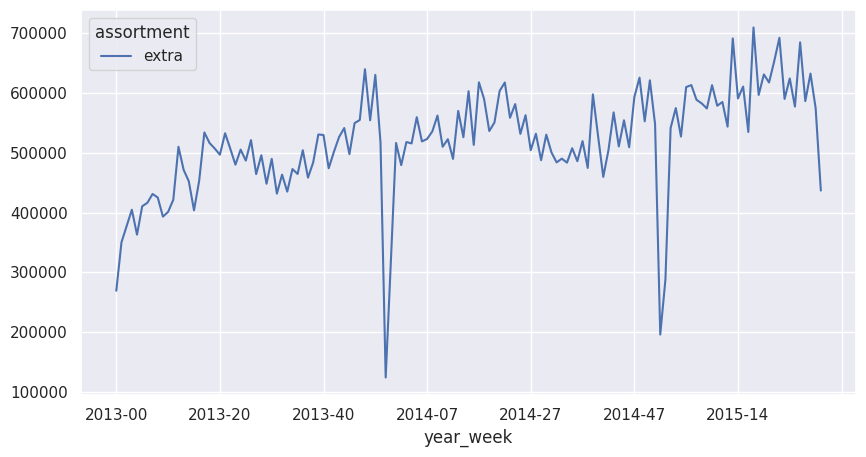

In [79]:
sns.set(rc={'figure.figsize':(10, 5)})
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
# aux1.head()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
# aux2.head()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

#### **H2** Lojas com competidores mais próximos deveriam vender menos.
**Falsa** - lojas com competidores mais próximos vendem mais.

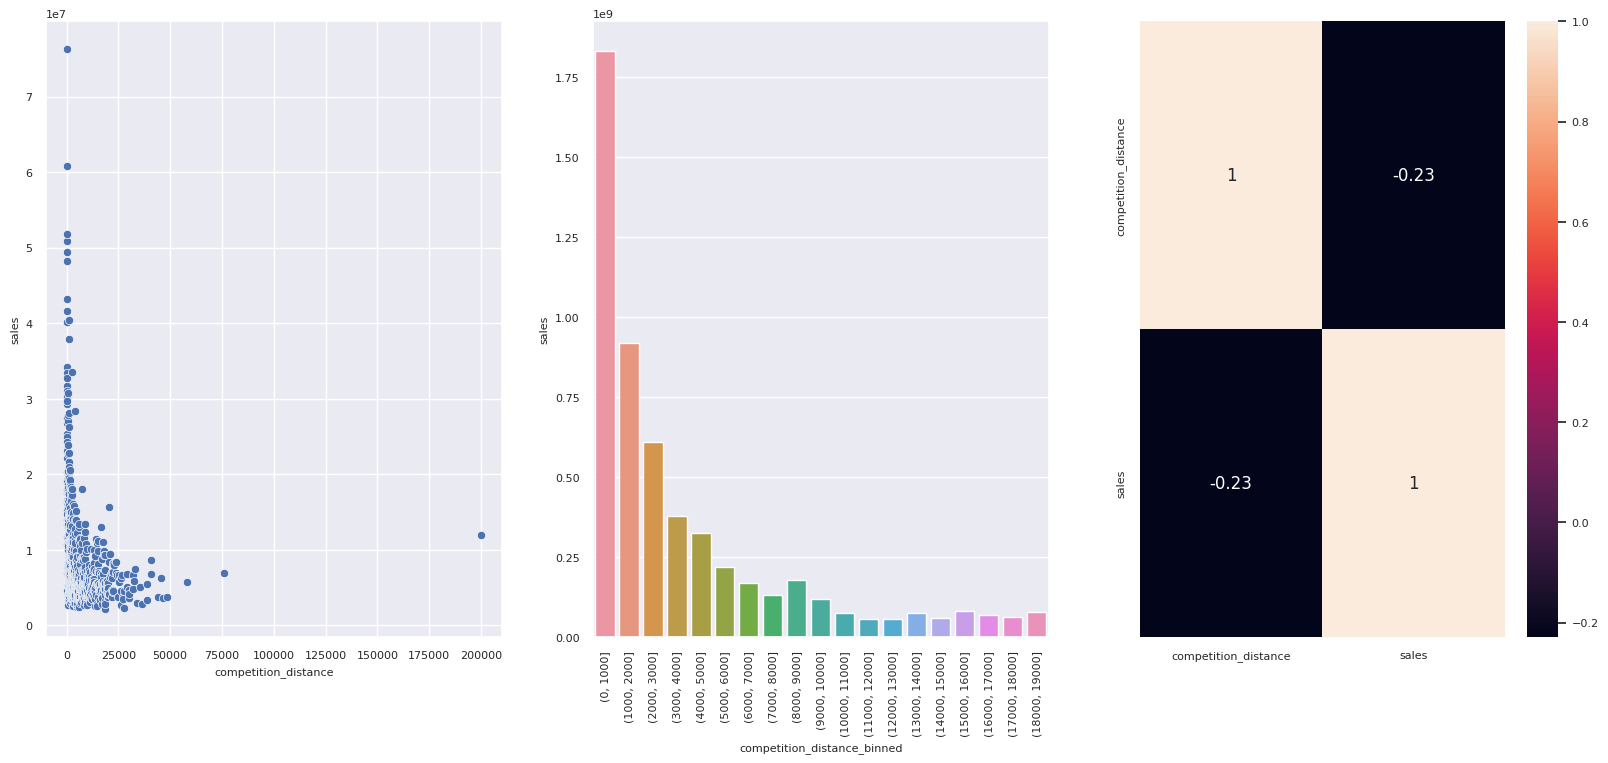

In [109]:
plt.rcParams['figure.figsize'] = (20, 8)
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 4

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot( 1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot( 1, 3, 2)
bins = list(np.arange( 0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot( 1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);
## caso o valor da correlação esteja deslocado
# bottom, top = x.get_ylim()
# x.set_ylim( bottom+0,5, top-0,5);

#### **H3** Lojas com competidores àmais tempo deveriam vender mais.
**Falsa** - lojas com competidores à mais tempo vendem menos!

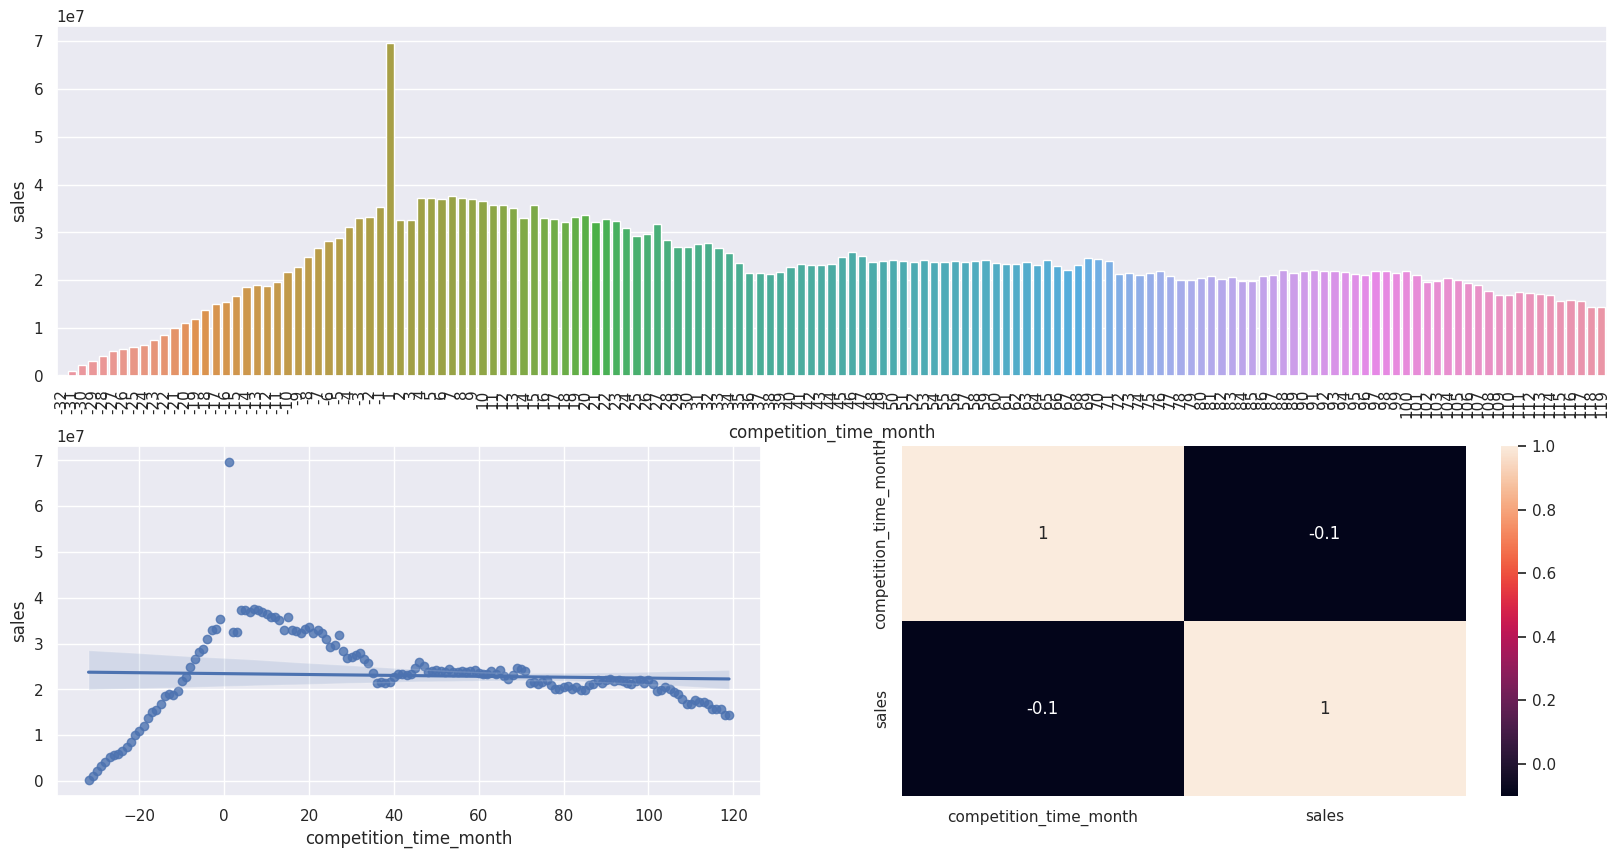

In [85]:
plt.rcParams['figure.figsize'] = (20,10);

plt.subplot( 2, 1, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 2, 2, 3 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 2, 2, 4 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
# bottom, top = x.get_ylim()
# x.set_ylim( bottom+0.5, top-0.5);

#### **H4** Lojas com promoções ativas por mais tempo deveriam vender mais.
**Falsa** - lojas com promoções ativas por mais tempo vendem menos, depois de um certo periodo de promoção.

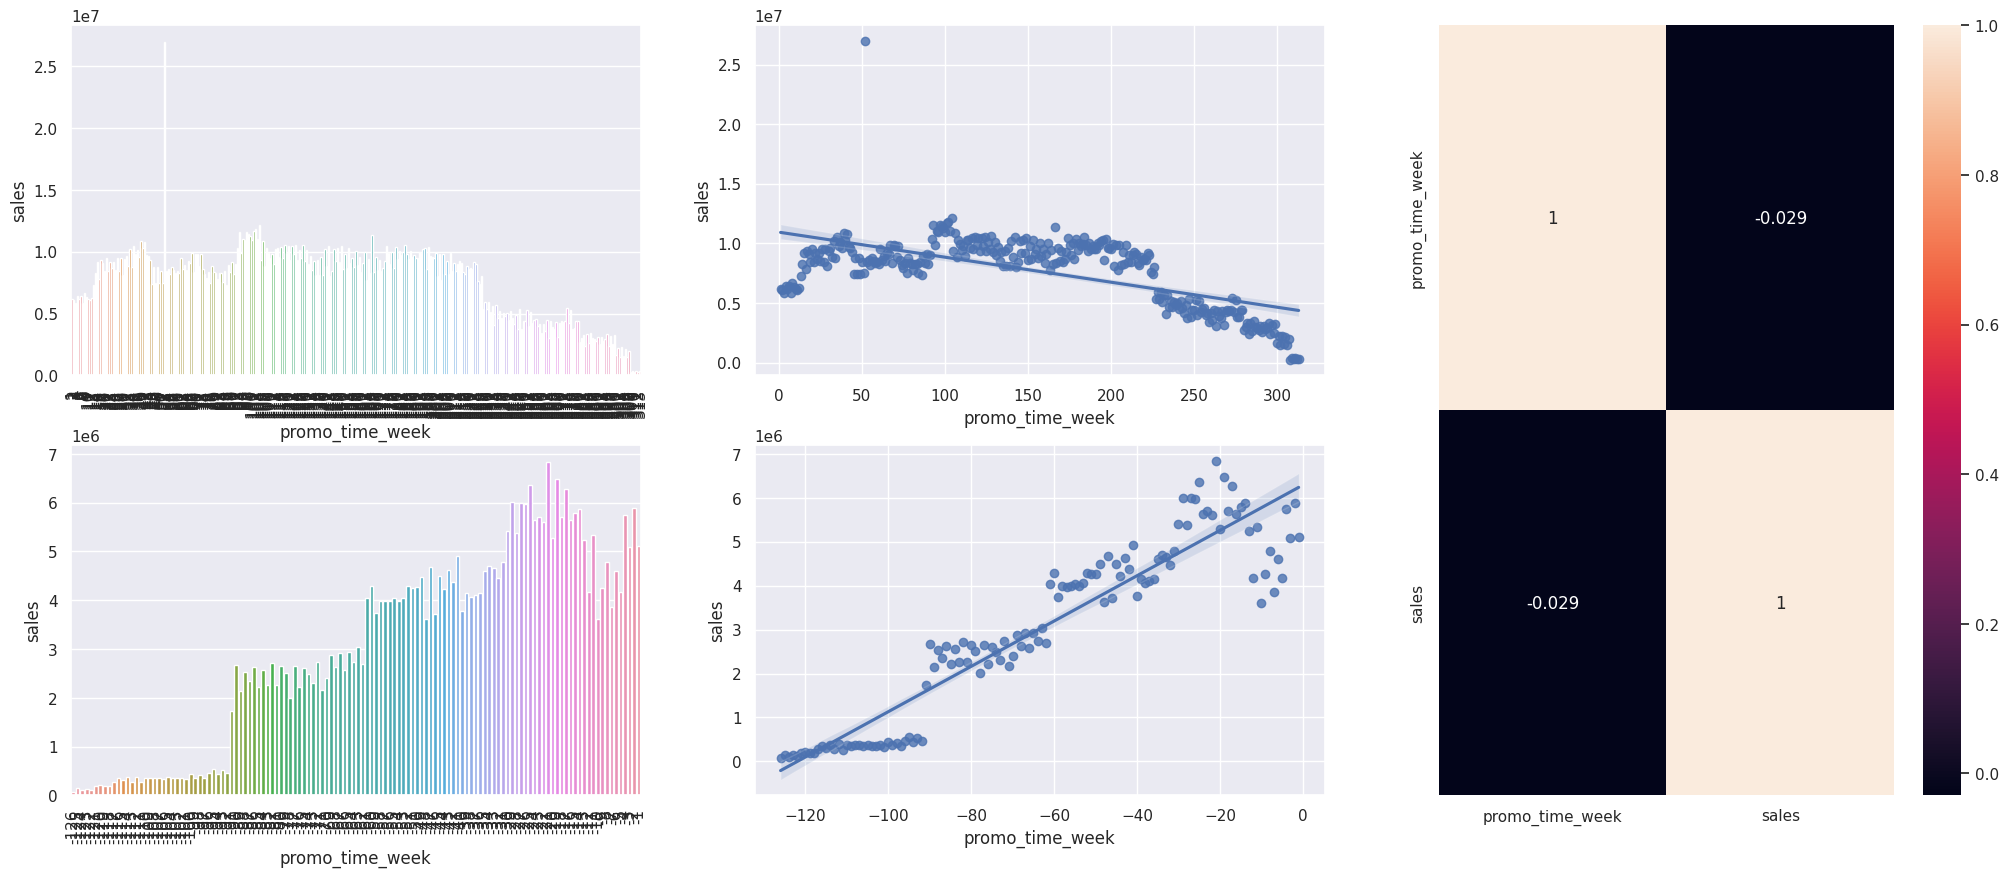

In [86]:
plt.rcParams['figure.figsize'] = (25,10);

aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### **H5** Lojas com mais dias de promoção deveriam vender mais.

#### **H6** Lojas com mais promoções consecutivas deveriam vender mais.
**Falsa** - lojas com mais promoções consecutivas vendem menos!

In [41]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


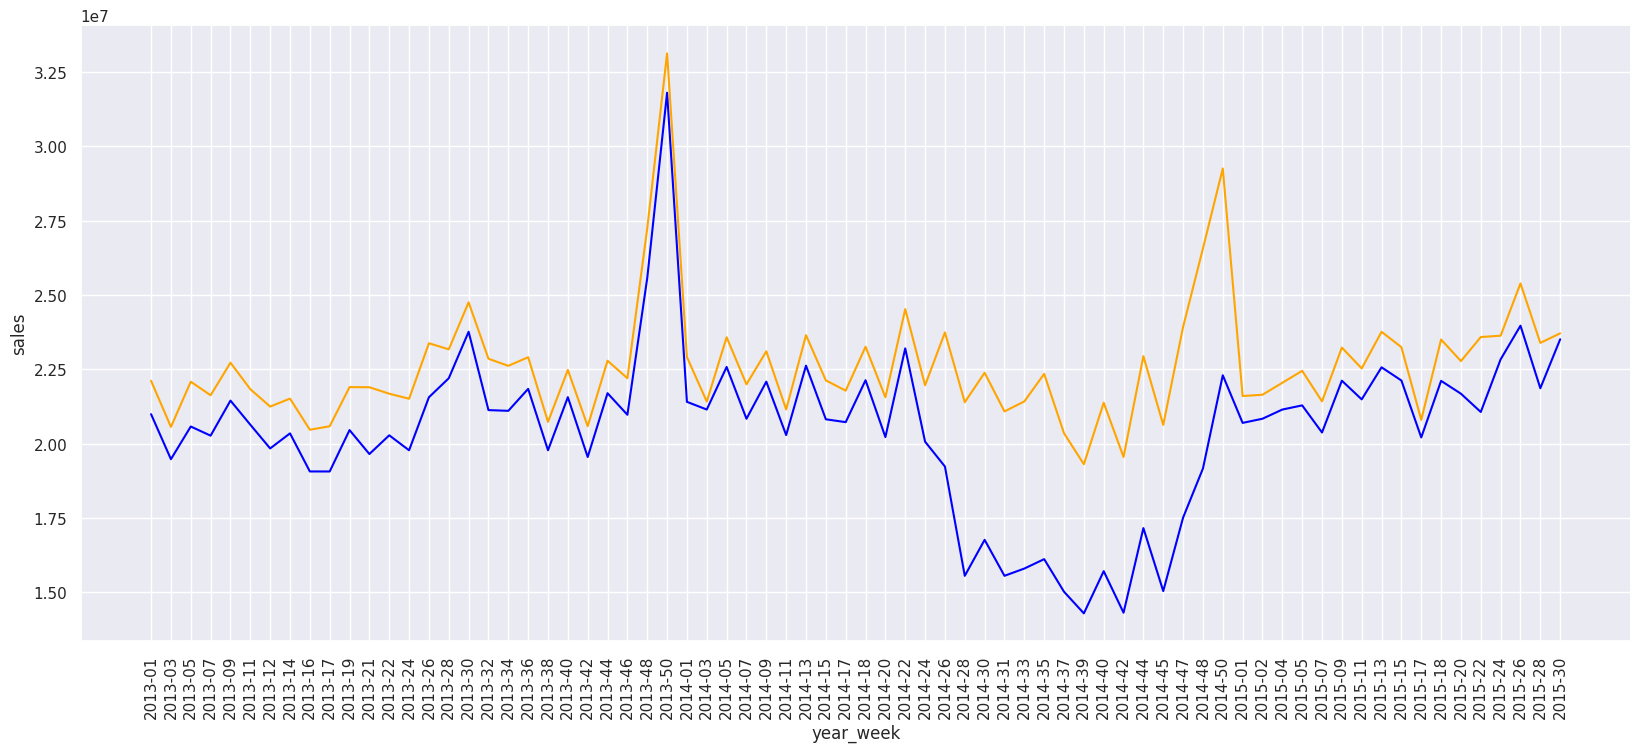

In [90]:
plt.rcParams['figure.figsize'] = (20, 8);

aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
# ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
# aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

fig, ax = plt.subplots()
sns.lineplot(x="year_week", y="sales", color='blue', data=aux1, ax=ax);
sns.lineplot(x="year_week", y="sales", color='orange', data=aux2, ax=ax);
plt.xticks(rotation=90);

#### **H7** Lojas abertas durante o feriado de Natal deveriam vender mais
**Falsa** Lojas abertas durante o feriado do Natal vendem menos!

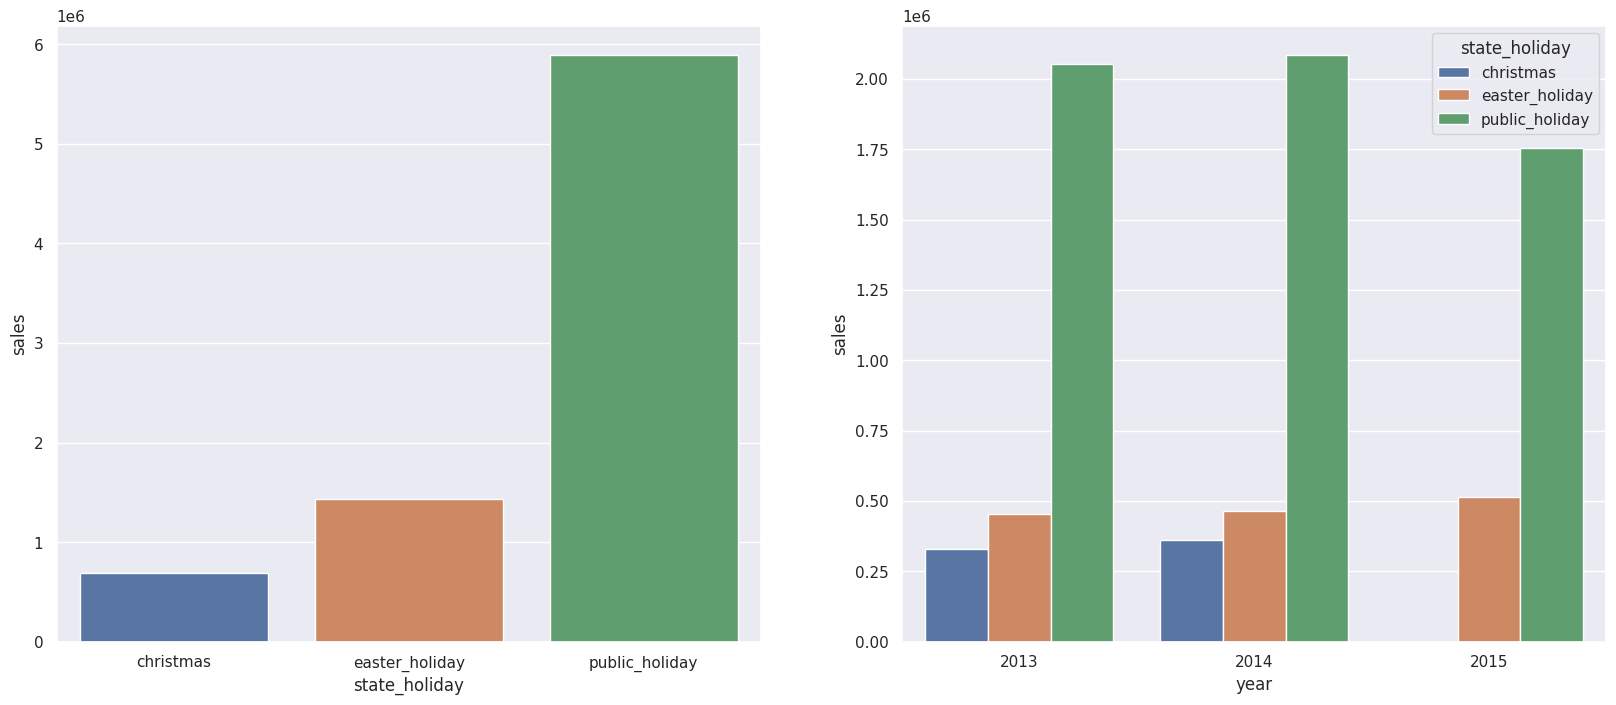

In [91]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

#### **H8** Lojas deveriam vender mais ao longo dos anos.
**Falsa** Lojas vendem menos ao longo dos anos.

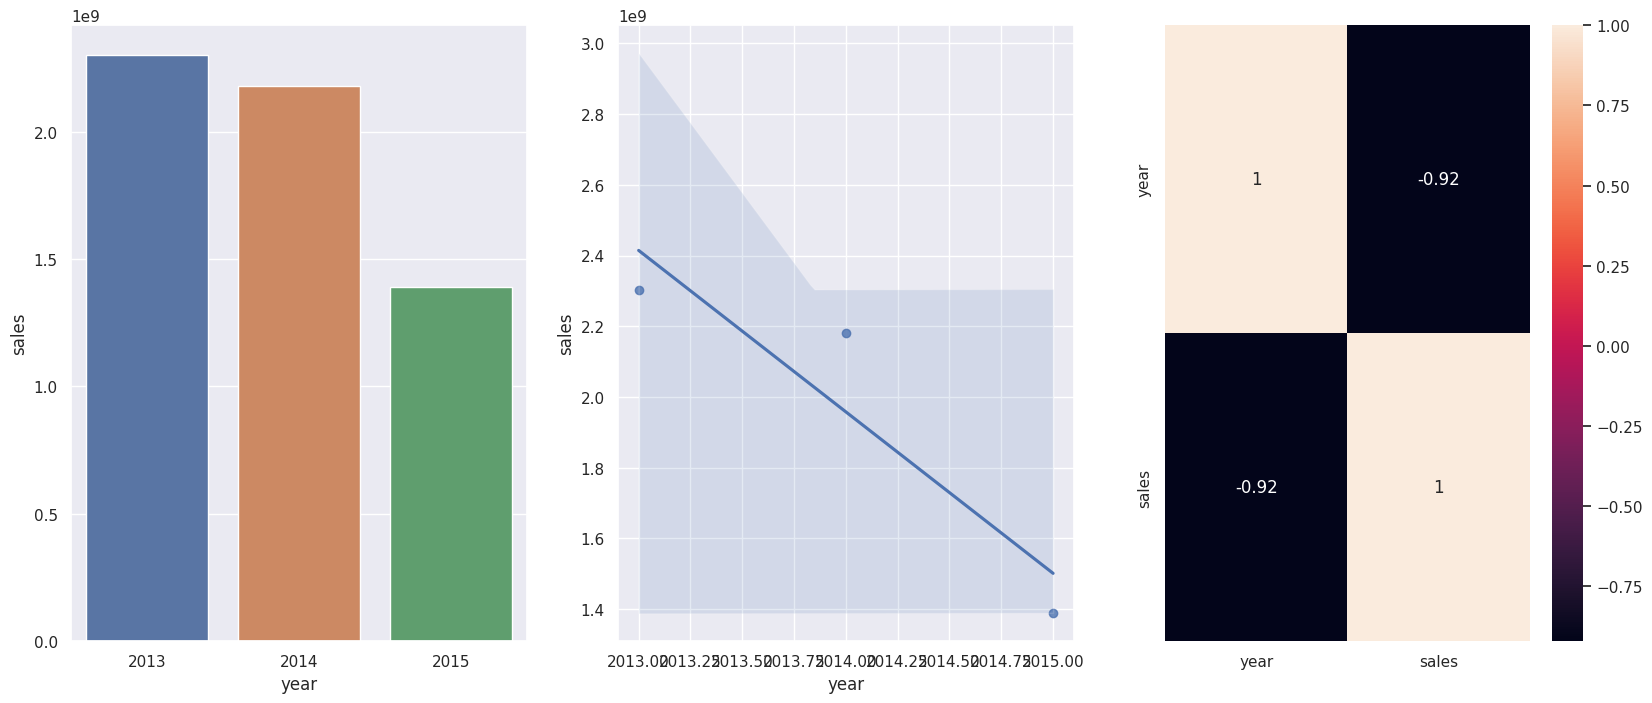

In [92]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### **H9** Lojas deveriam vender mais no segundo semestre do ano.
**Falsa** - lojas vendem menos no segundo semestre do ano!

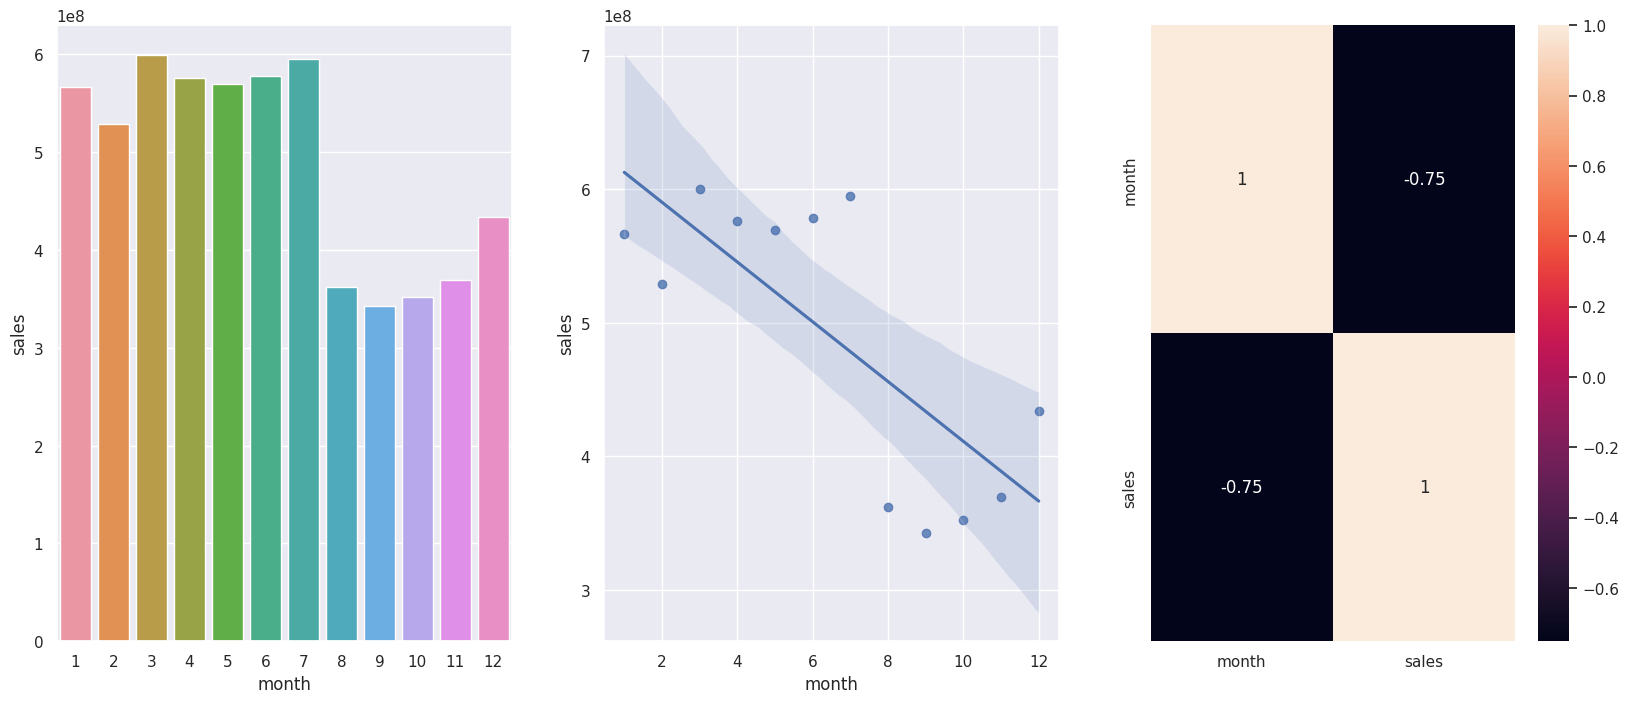

In [93]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### **H10** Lojas deveriam vender mais depois do dia 10 de cada mês.
**Verdadeira** - lojas vendem mais depois do dia 10 de cada mês!

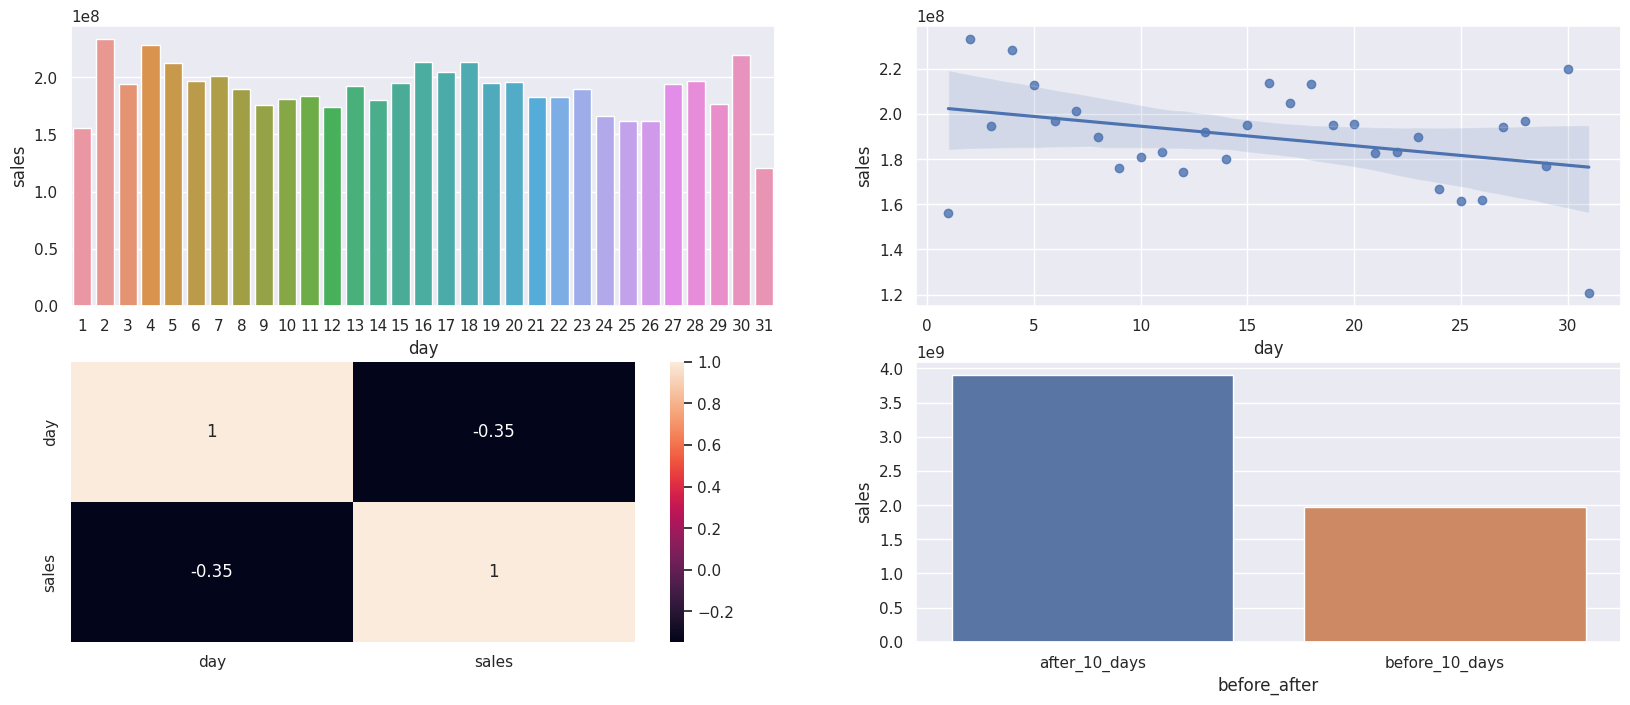

In [94]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

#### **H11** Lojas deveriam vender menos aos finais de semana.
**Verdadeira** - lojas vendem menos aos finais de semana.

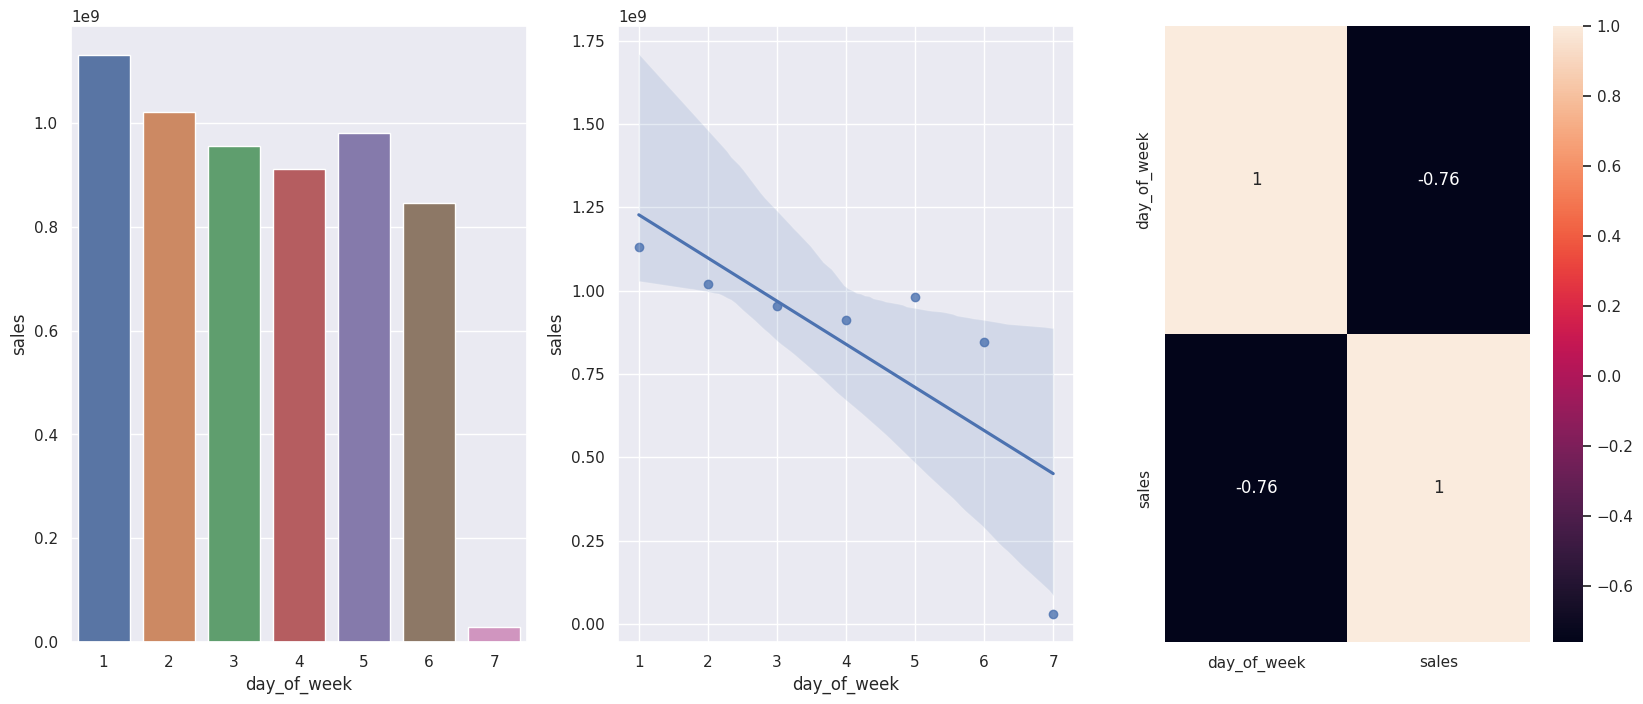

In [95]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### **H12** Lojas deveriam vender menos durante os feriados escolares
**Verdadeira** - lojas vendem menos durante os feriados escolares, exceto os meses de julho e agosto.

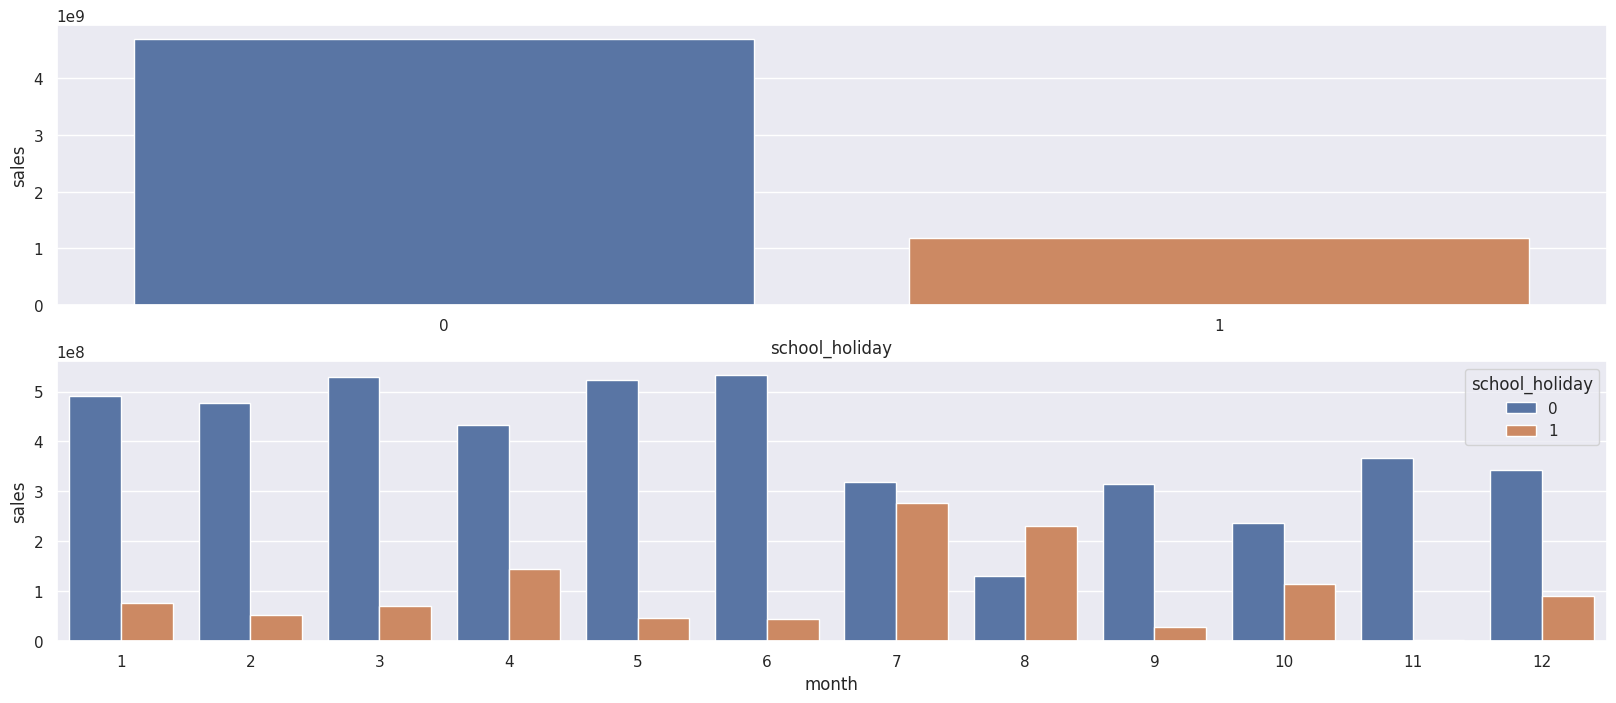

In [96]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).sum().reset_index()

plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### 4.2.2 Resumo das Hipóteses

In [49]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

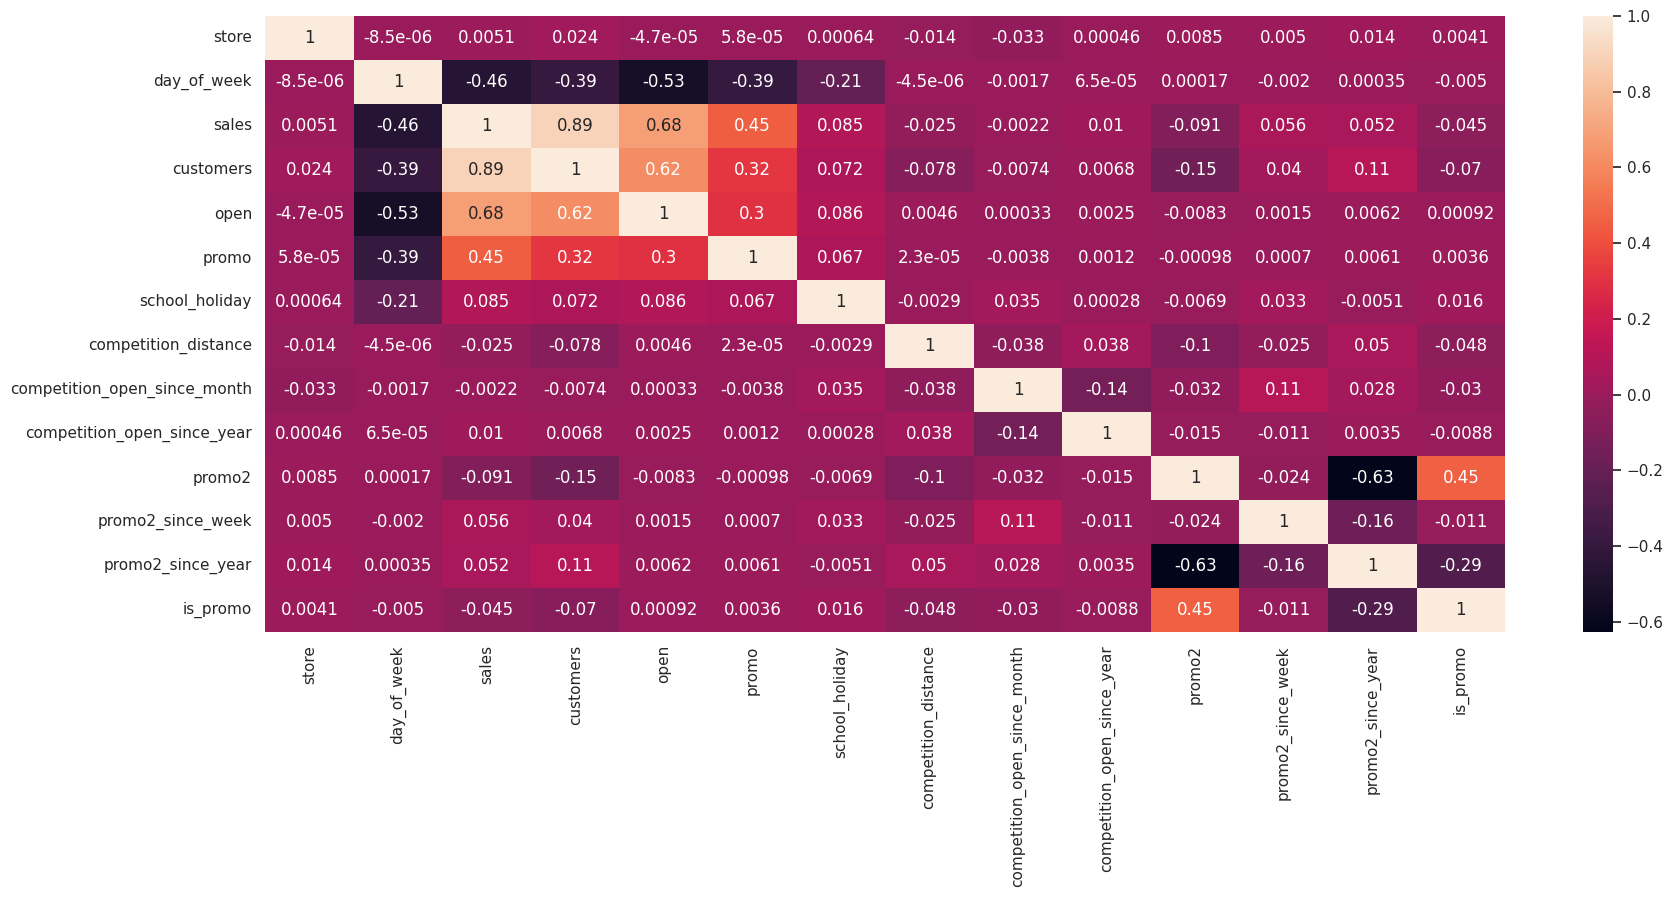

In [97]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );
sns.set(font_scale=1.8)


### 4.3.2 Categorical Attributes

In [51]:
a = df4.select_dtypes(include='object')

In [52]:
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [53]:
a[(a['state_holiday'] == 'christmas') & (a['store_type'] == 'a')]

,state_holiday,store_type,assortment,year_week
241499,christmas,a,extended,2014-51
241977,christmas,a,extended,2014-51
616339,christmas,a,extended,2013-51
616908,christmas,a,extended,2013-51


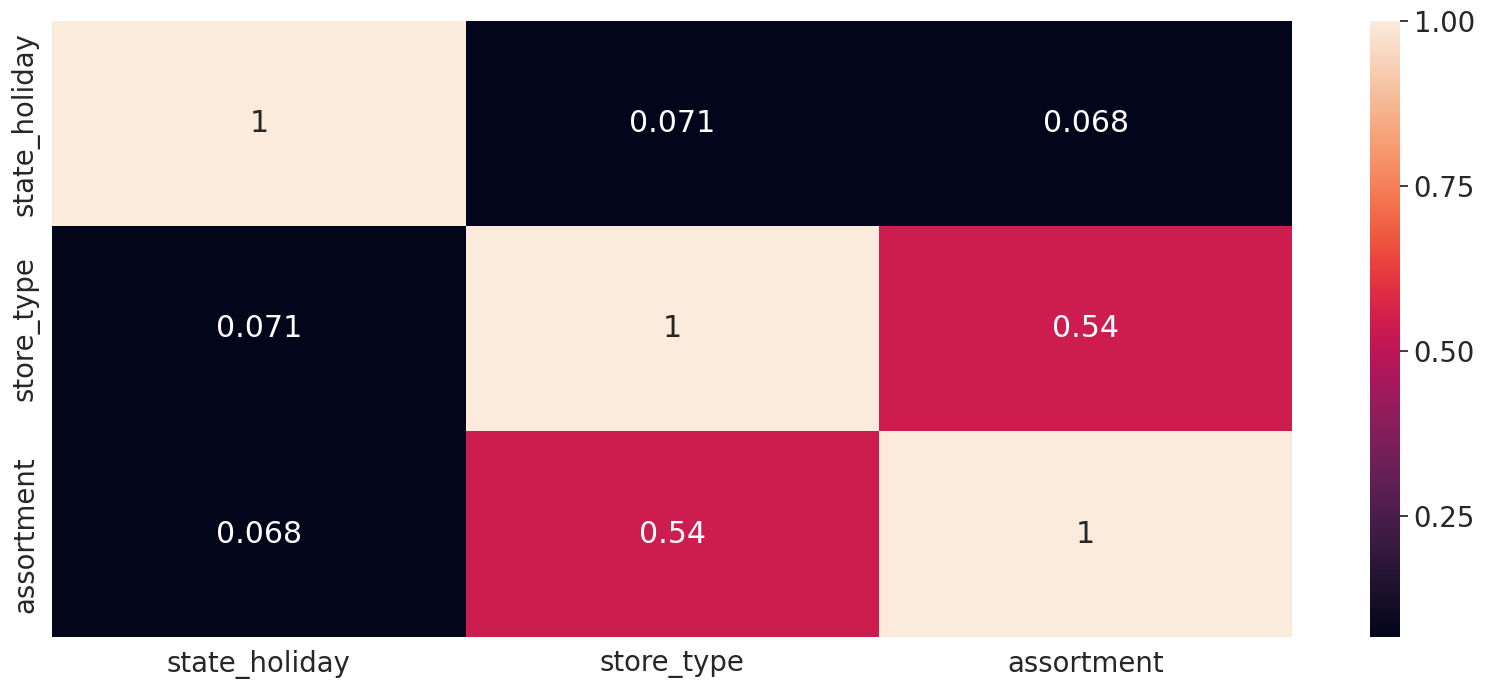

In [98]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramers_v( a['state_holiday'], a['state_holiday'] )
a2 = cramers_v( a['state_holiday'], a['store_type'] )
a3 = cramers_v( a['state_holiday'], a['assortment'] )
a4 = cramers_v( a['store_type'], a['state_holiday'] )
a5 = cramers_v( a['store_type'], a['store_type'] )
a6 = cramers_v( a['store_type'], a['assortment'] )
a7 = cramers_v( a['assortment'], a['state_holiday'] )
a8 = cramers_v( a['assortment'], a['store_type'] )
a9 = cramers_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                   'store_type': [a4, a5, a6],
                   'assortment': [a7, a8, a9] })

d = d.set_index( d.columns )
sns.heatmap( d, annot=True )
sns.set(font_scale=5)

# 5.0 Data Preparation

In [55]:
df5 = df4.copy()

## 5.1 Normalize

## 5.2 Rescaling

In [56]:
a = df5.select_dtypes(include=['int64', 'float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,4,0


In [57]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
# pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
# pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
# pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
# pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

## 5.3 Transformation

### 5.3.1 Encoding

In [58]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
# pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2 Response Variable Transformation

In [59]:
# Logarithm transformation

df5['sales'] = np.log1p(df5['sales'])
# sns.displot(df5['sales'])

### 5.3.3 Nature Transformation

In [60]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin ( x* ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos ( x* ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin ( x* ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos ( x* ( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin ( x* ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos ( x* ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin ( x* ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos ( x* ( 2. * np.pi/52 ) ) )

# 6.0 Feature Selection

In [61]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [62]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competiton_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [63]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [64]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format(X_train['date'].min()))
print( 'Training Max Date: {}'.format(X_train['date'].max()))

print( '\nTest Min Date: {}'.format(X_test['date'].min()))
print( 'Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [65]:
# training and test dataset for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1)

# define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n)

### 6.2.1 Best Features from Boruta

In [62]:
# cols_selected = boruta.support_.tolist()

# best features
# X_train_fs = X_train.drop(['date', 'sales'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

# not selected boruta
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [63]:
# cols_selected_boruta

In [64]:
# cols_not_selected_boruta

## 6.3 Manual Feature Selection

In [66]:
# add coluna 'month_sin' não selecionada pelo Boruta
cols_selected_boruta = [
'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_sin',
'month_cos',
'day_sin',
'day_cos',
'week_of_year_sin',
'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# definindo colunas - Cross Validation
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 Machine Learning Modelling

In [67]:
# Separação do conjunto de dados para executar os algoritmos de ML
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [68]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [68]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [69]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/-295.63,0.3 +/-0.02,2952.52 +/-468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [70]:
# model
lrr = Lasso( alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Lasso - Cross Validation

In [71]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/-341.5,0.29 +/-0.01,3057.75 +/-504.26


## 7.4 Random Forest Regressor

In [72]:
# model
rf = RandomForestRegressor (n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738


### 7.4.1 Random Forest Regressor - Cross Validation

In [73]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFOLD Number: 5

KFOLD Number: 4

KFOLD Number: 3

KFOLD Number: 2

KFOLD Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.7 +/-219.24,0.12 +/-0.02,1256.59 +/-320.28


## 7.5 XGBoost Regressor

In [74]:
# model
model_xgb = xgb.XGBRegressor().fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,868.958204,0.130309,1238.550842


### 7.5.1 XGBoost Regressor - Cross Validation

In [75]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv   


KFOLD Number: 5

KFOLD Number: 4

KFOLD Number: 3

KFOLD Number: 2

KFOLD Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1064.94 +/-178.65,0.15 +/-0.02,1519.92 +/-242.12


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [76]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738
0,XGBoost Regressor,868.958204,0.130309,1238.550842
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2 Real Performance - Cross Validation

In [77]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.7 +/-219.24,0.12 +/-0.02,1256.59 +/-320.28
0,XGBoost Regressor,1064.94 +/-178.65,0.15 +/-0.02,1519.92 +/-242.12
0,Linear Regression,2081.73 +/-295.63,0.3 +/-0.02,2952.52 +/-468.37
0,Lasso,2116.38 +/-341.5,0.29 +/-0.01,3057.75 +/-504.26


# 8.0 Hyperparameter Fine Tuning

## 8.1 Random Search

In [69]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 5

In [79]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample (v, 1)[0] for k, v in param.items() }
#    print ( hp )
#
#    # model
#    model_xgb = xgb.XGBRegressor( objective= 'reg:squarederror',
#                                  n_estimators= hp['n_estimators'],
#                                  eta= hp['eta'],
#                                  max_depth= hp['max_depth'],
#                                  subsample= hp['subsample'],
#                                  colsample_bytree= hp['colsample_bytree'],
#                                  min_child_weight= hp['min_child_weight']
#                                  )
#    # performance
#    result = cross_validation ( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
#    final_result = pd.concat( [final_result, result])

# final_result

## 8.2 Final Model

In [70]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
}

In [71]:
# model

model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,760.460212,0.114435,1090.293111


# 9.0 Tradução e Interpretação do Erro

In [110]:
df9 = X_test [ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1 Business Performance

In [73]:
# sum of predicition
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'])).reset_index().rename ( columns = {0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'])).reset_index().rename( columns = {0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge( df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]
df92.sort_values( 'MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,109548.34375,106169.010832,112927.676668,3379.332918,0.611551
908,909,225183.93750,217398.535029,232969.339971,7785.402471,0.515392
875,876,195381.09375,191315.102178,199447.085322,4065.991572,0.328450
285,286,162921.25000,162178.178718,163664.321282,743.071282,0.279653
901,902,188716.06250,187613.142050,189818.982950,1102.920450,0.275798


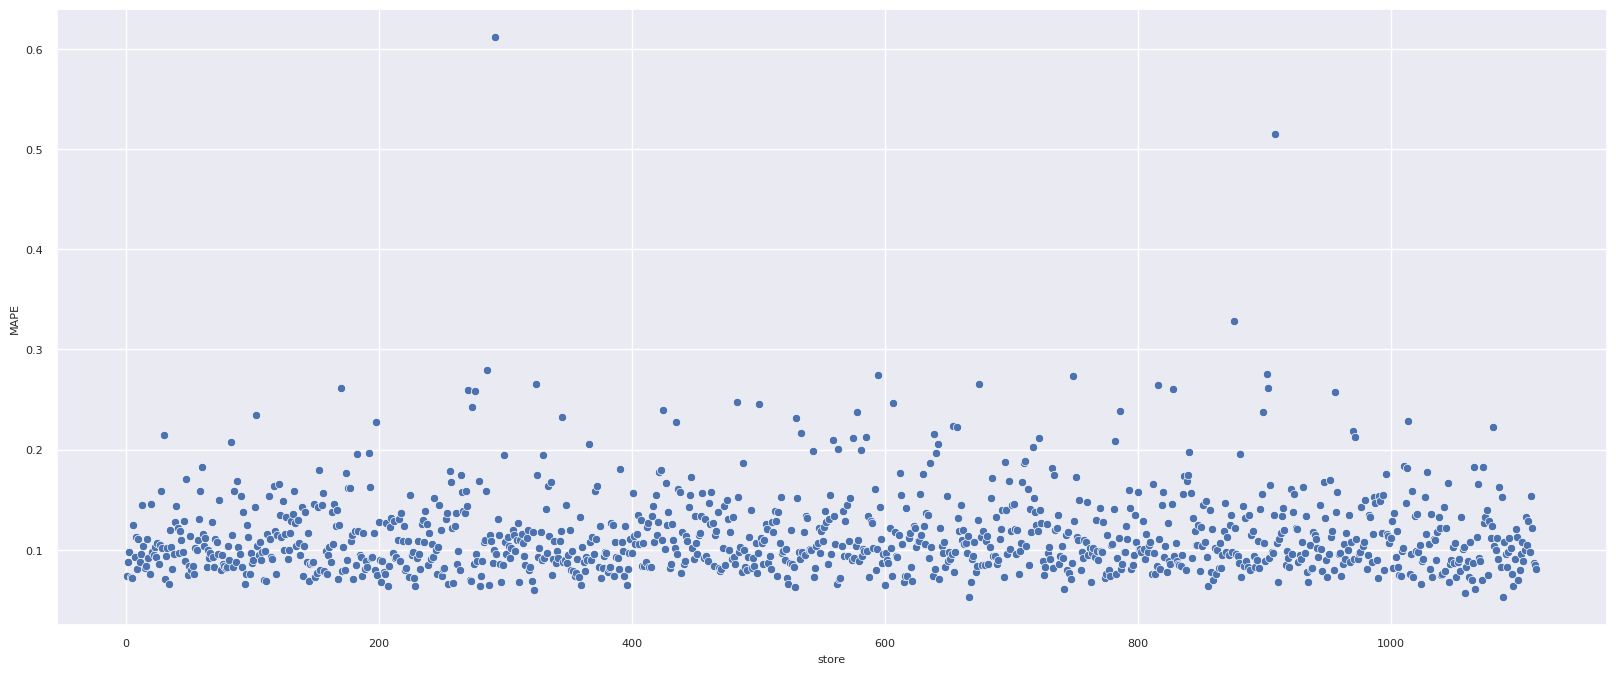

In [74]:
plt.rcParams['figure.figsize'] = (20, 8)
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 8
sns.scatterplot( x='store', y='MAPE', data=df92);

## 9.2 Total Performance

In [75]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0).reset_index().rename( columns={'index': 'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map( '${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"$287,024,320.00"
1,worst_scenario,"$286,173,202.82"
2,best_scenario,"$287,875,399.02"


## 9.3 Machine Learning Performance

In [111]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

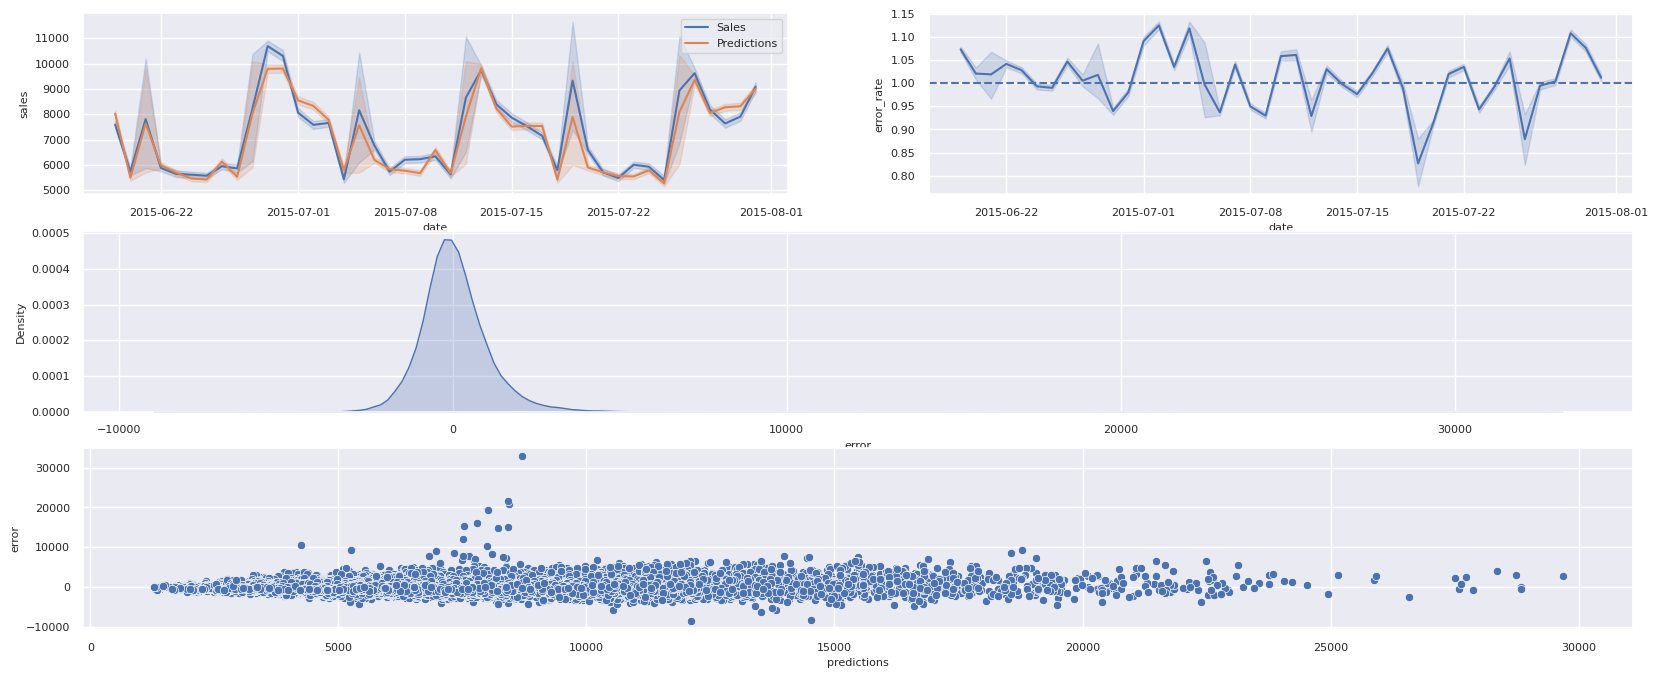

In [112]:
plt.rcParams['figure.figsize'] = (20, 8)
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 8
grid = GridSpec(3,2)

plt.subplot(grid[0,0])
sns.lineplot( x='date', y='sales', data=df9, label='Sales');
sns.lineplot( x='date', y='predictions', data=df9, label='Predictions');

plt.subplot(grid[0,1])
sns.lineplot( x='date', y='error_rate', data=df9);
plt.axhline( 1, linestyle='--')

plt.subplot(grid[1,:])
sns.kdeplot( df9['error'], fill=True, palette='magma');

plt.subplot(grid[2,:])
sns.scatterplot( data=df9, x='predictions', y='error');

# 10.0 Deploy Model to Production

In [113]:
# save trained model
# pickle.dump( model_xgb_tuned, open( 'model/model_rossmann.pkl', 'wb'))

## 10.1 Rossmann Class

In [4]:
import math
import pickle
import datetime
import inflection
import numpy as np
import pandas as pd

class Rossmann(object):
    def __init__(self):
        self.home_path = '/home/marcelo/repos_cds/ds_producao/'
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        self.promo_time_week               = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))

    def data_cleaning(self, df1):

        # 1.1 Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 
                    'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        # rename
        df1.columns = cols_new

        # 1.3 Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        # 1.5 Fillout NA
        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month 
                                                        if math.isnan(x['competition_open_since_month']) 
                                                        else x['competition_open_since_month'], axis=1)

        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year 
                                                        if math.isnan(x['competition_open_since_year']) 
                                                        else x['competition_open_since_year'], axis=1)

        # promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week 
                                                        if math.isnan(x['promo2_since_week']) 
                                                        else x['promo2_since_week'], axis=1)

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year 
                                                        if math.isnan(x['promo2_since_year']) 
                                                        else x['promo2_since_year'], axis=1)

        # promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df1['promo_interval'].fillna(0, inplace=True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 
                                                                                 if x ['month_map'] in x ['promo_interval'].split(',') else 0, axis=1)
        
        # 1.6 Change Types
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

        return df1
    
    def feature_engineering(self, df2):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

        # competition since
        df2['competiton_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competiton_since'])/30).apply(lambda x: x.days).astype(int)
                                            
        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = (( df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # 3.1 Filtragem das linhas
        df2 = df2[df2['open'] !=0]

        # 3.2 Seleção das colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)

        return df2
    
    def data_preparation(self, df5):

        # Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week.fit_transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin ( x* ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos ( x* ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin ( x* ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos ( x* ( 2. * np.pi/12 ) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin ( x* ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos ( x* ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin ( x* ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos ( x* ( 2. * np.pi/52 ) ) )

        # add coluna 'month_sin' não selecionada pelo Boruta
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',
                                'competition_open_since_month', 'competition_open_since_year', 'promo2',
                                'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                                'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
                                'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[cols_selected]
    

    
    def get_prediction(self, model, original_data, test_data):
        # Prediction
        pred = model.predict(test_data)

        # Joining pred into the original data
        original_data['prediction'] = np.expm1(pred)

        return original_data.to_json(orient='records', date_format='iso')

## 10.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, Response, request
from rossmann.Rossmann import Rossmann

# Loading model
model = pickle.load(open('/home/marcelo/repos_cds/ds_producao/model/model_rossmann.pkl', 'rb'))

# Initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])

def rossmann_predict():
    test_json = request.get_json()

    if test_json: # checking data
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])

        else: # multiple examples
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # Instantiate Rossmann class
        pipeline = Rossmann()

        # Data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # Feature Engineering
        df2 = pipeline.feature_engineering(df1)

        # Data Preparation
        df3 = pipeline.data_preparation(df2)

        # Prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response

    else:
        return Response('{}', status=200, mimetype='application/json')


if __name__ == '__main__':
    app.run('0.0.0.0')

## 10.3 API Tester

In [5]:
# Test dataset
df10 = pd.read_csv('data/raw/test.csv')

In [17]:
# Merging test + store dataset
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# Choosing only one store for prediction test
df_test = df_test[df_test['Store'] == 45]

# Removing closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [18]:
# Converting dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [19]:
# API Call
url = 'https://webapp-rossmann-8290.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [20]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [21]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for x in range(len(d2)):
    print('Store number {} will sell ${:,.2f} in the next 6 weeks'.format(
           d2.loc[x, 'store'],
           d2.loc[x, 'prediction']))

Store number 45 will sell $182,064.52 in the next 6 weeks
